In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import warnings
import datetime

RANDOM_SEED = 42
warnings.filterwarnings('ignore')

In [2]:
# importing dataset
filePath = 'C:\\Users\\iaugu\\Google Drive (z.data.analytics@gmail.com)\\'
filePath = filePath + 'Process Quality Control - PLS project\\anomaly_detection'
fileName = 'process_data.csv'
data = pd.read_csv(os.path.join(filePath, fileName))
data.head()

solutionA_inletFlowRate  water_inletFlowRate  solutionB_inletFlowRate  \
0                 2.488026             7.022645                 0.493385   
1                 2.564250             7.210281                 0.521194   
2                 2.578252             7.356546                 0.530302   
3                 2.438043             6.534329                 0.492974   
4                 2.222003             6.377055                 0.496884   

   componentA_inletConcentration  componentB_inletConcentration  \
0                       7.415100                      12.313350   
1                       7.001721                      12.246920   
2                       7.039666                      11.964474   
3                       7.097230                      12.032390   
4                       7.185610                      11.724253   

   solutionA_inletTemperature  water_inletTemperature  \
0                   29.232410               10.161989   
1                   30.321235                9.813532   
2                   29.647262                9.939467   
3                   29.074167               10.126576   
4                   31.573436               10.024570   

   solutionB_inletTemperature  componentA_outletConcentration  \
0                   29.204568                        1.747784   
1                   29.937081                        1.649414   
2                   30.877037                        1.648039   
3                   30.156679                        1.716432   
4                   28.878612                        1.637008   

   componentB_outletConcentration  componentC_outletConcentration  \
0                        0.414548                        0.192728   
1                        0.431103                        0.188865   
2                        0.433679                        0.172601   
3                        0.403386                        0.223285   
4                        0.403802                        0.236659   

   outletTemperature  
0          96.089927  
1          95.193304  
2          88.922935  
3         108.955373  
4         114.179174

In [3]:
# checking data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   solutionA_inletFlowRate         5000 non-null   float64
 1   water_inletFlowRate             5000 non-null   float64
 2   solutionB_inletFlowRate         5000 non-null   float64
 3   componentA_inletConcentration   5000 non-null   float64
 4   componentB_inletConcentration   5000 non-null   float64
 5   solutionA_inletTemperature      5000 non-null   float64
 6   water_inletTemperature          5000 non-null   float64
 7   solutionB_inletTemperature      5000 non-null   float64
 8   componentA_outletConcentration  5000 non-null   float64
 9   componentB_outletConcentration  5000 non-null   float64
 10  componentC_outletConcentration  5000 non-null   float64
 11  outletTemperature               5000 non-null   float64
dtypes: float64(12)
memory usage: 468.9

All data attributes are numeric and there are no missing data.

The dataset have 11 process variables : 7 of them are control variables (input) and the remaining 4 are controlled variables (output).

Input variables:
- component A inlet flow rate
- water inlet flow rate
- component B inlet flow rate
- component A inlet concentration
- component B inlet concentration
- solution A inlet temperature
- water inlet temperature
- solution B inlet temperature

Output variables:
- component A output concentration
- component B output concentration
- component C output concentration
- outlet temperature

## **1. Main Objective**

In this process, there are significant variability in reactor output variables. Its is necessary to train a model that can identify anomalies and to propose the necessary corrections to ensure quality control.
However, there are several output variables that need to be controled, because each one has its own importance. The methodology have to permit such multivariable approach.



### 1.1. Specific Objectives

- to do preliminary data analysis to outliers and errors identification
- to do exploratory data analysis to identify correlations
- to evaluate process using statistical process control approach
- to build a anomaly detection model that allow proper quality control using only input variables
- to validate the proposed model
- to propose an action plan to drive anomalous process back to "quality" region

## **2. Exploratory Data Analysis**


In [4]:
def control_chart(data, var_name, n = 5):

  # this function builds the control charts of mean and ranges por a specific
  # process, using a sampling plan of n point per minute

  to_monitor = pd.DataFrame(data[var_name], columns=[var_name])

  # dictionary of constants for statistical process control calculations
  d2_dict = {2: 1.128, 3: 1.693, 4: 2.059, 5: 2.326, 6: 2.534, 7: 2.704,
            8: 2.847, 9: 2.970, 10: 3.078, 11: 3.173, 12: 3.258, 13: 3.336,
            14: 3.407, 15: 3.472}
  d3_dict = {2: 0.853, 3: 0.888, 4: 0.880, 5: 0.864, 6: 0.848, 7: 0.833,
            8: 0.820, 9: 0.808, 10: 0.797, 11: 0.787, 12: 0.778, 13: 0.770,
            14: 0.763, 15: 0.756}

  # grouping of values
  to_monitor_mean = to_monitor.groupby(to_monitor.index//n).agg({var_name:'mean'})
  to_monitor_max = to_monitor.groupby(to_monitor.index//n).agg({var_name:'max'})
  to_monitor_min = to_monitor.groupby(to_monitor.index//n).agg({var_name:'min'})

  to_monitor_full = pd.concat([to_monitor_mean, to_monitor_max], axis = 1)
  to_monitor_full = pd.concat([to_monitor_full, to_monitor_min], axis = 1)

  to_monitor_full.columns = ['Avg','Max','Min']
  to_monitor_full['Amp'] = to_monitor_full['Max'] - to_monitor_full['Min']

  to_monitor_full.drop(['Max','Min'], axis = 1, inplace = True)

  # statistical control chart - range chart
  d2 = d2_dict[n]
  d3 = d3_dict[n]
  R_bar = to_monitor_full['Amp'].mean()
  R_sigma = R_bar*(d3/d2)
  LSC_R = R_bar + 3*R_sigma
  LIC_R = R_bar - 3*R_sigma

  # statistical process control - average chart
  A2 = (3*R_bar)/(d2*np.sqrt(n))
  X_bar = to_monitor_full['Avg'].mean()
  LSC_X = X_bar + (A2*R_bar)
  LIC_X = X_bar - (A2*R_bar)

  plt.figure(figsize=(13,15))
  plt.subplot(2,1,1)
  plt.plot(to_monitor_full['Amp'], 'k.-')
  plt.axhline(y = LSC_R, color = 'r', linestyle = '--')
  plt.axhline(y = LIC_R, color = 'r', linestyle = '--')
  plt.axhline(y = R_bar, color = 'r', linestyle = '--')
  plt.ylabel(var_name, fontsize = 16)
  plt.xlabel('Samples', fontsize = 16)
  plt.title('Control Chart - Ranges - ' + var_name, fontsize = 20)
  plt.grid()

  plt.subplot(2,1,2)
  plt.plot(to_monitor_full['Avg'], 'k.-')
  plt.axhline(y = LSC_X, color = 'r', linestyle = '--')
  plt.axhline(y = LIC_X, color = 'r', linestyle = '--')
  plt.axhline(y = X_bar, color = 'r', linestyle = '--')
  plt.ylabel(var_name, fontsize = 16)
  plt.xlabel('Samples', fontsize = 16)
  plt.title('Control Charts - Averages - ' + var_name, fontsize = 20)
  plt.grid()

  plt.show()

  # return useful values
  results = {'LIC_R': LIC_R, 'R_bar': R_bar,'LSC_R': LSC_R, 
             'LIC_X': LIC_X, 'X_bar': X_bar, 'LSC_X': LSC_X}

  return results

In [5]:
# distribution exploratory analysis
def hist_boxplot(data, var_name):
  # this function plots histograms and boxplots for the selected variable
  to_monitor = pd.DataFrame(data[var_name], columns=[var_name])

  # vertical lines parameters calculation
  avg = to_monitor[var_name].mean()
  std = to_monitor[var_name].std()

  x1_vline = avg - 3*std
  x2_vline = avg + 3*std

  # histogram and boxplot construction
  fig = plt.figure(figsize=(20,10))
  ax1 = fig.add_subplot(1,2,1)
  sns.histplot(to_monitor[var_name], stat = 'density', kde = True, element = 'step', alpha = 0.7)
  ax1.axvline(x = x1_vline, color = 'r', linestyle = '--')
  ax1.axvline(x = x2_vline, color = 'r', linestyle = '--')
  ax1.set_ylabel('Density', fontsize = 16)
  ax1.set_xlabel(var_name, fontsize = 16)
  ax1.set_title('Histogram - ' + var_name + '\nVertical Lines show +- 3 Std. Deviations', fontsize = 20)
  
  ax2 = fig.add_subplot(1,2,2)
  sns.boxplot(x = to_monitor[var_name], orient = 'h', color = 'g')
  ax2.axvline(x = x1_vline, color = 'r', linestyle = '--')
  ax2.axvline(x = x2_vline, color = 'r', linestyle = '--')
  ax2.set_xlabel(var_name, fontsize = 16)
  ax2.set_title('Boxplot - ' + var_name + '\nVertical Lines show +- 3 Std. Deviations', fontsize = 20)
  
  plt.suptitle('Variability and Distribution Analysis - ' + var_name, size = 22)

In [6]:
# checking number of missing data
data.isna().sum()

solutionA_inletFlowRate           0
water_inletFlowRate               0
solutionB_inletFlowRate           0
componentA_inletConcentration     0
componentB_inletConcentration     0
solutionA_inletTemperature        0
water_inletTemperature            0
solutionB_inletTemperature        0
componentA_outletConcentration    0
componentB_outletConcentration    0
componentC_outletConcentration    0
outletTemperature                 0
dtype: int64

There are no missing data. All the columns and rows are filled with valid values. Let's check the dataset for the presence of outliers values in each variable.

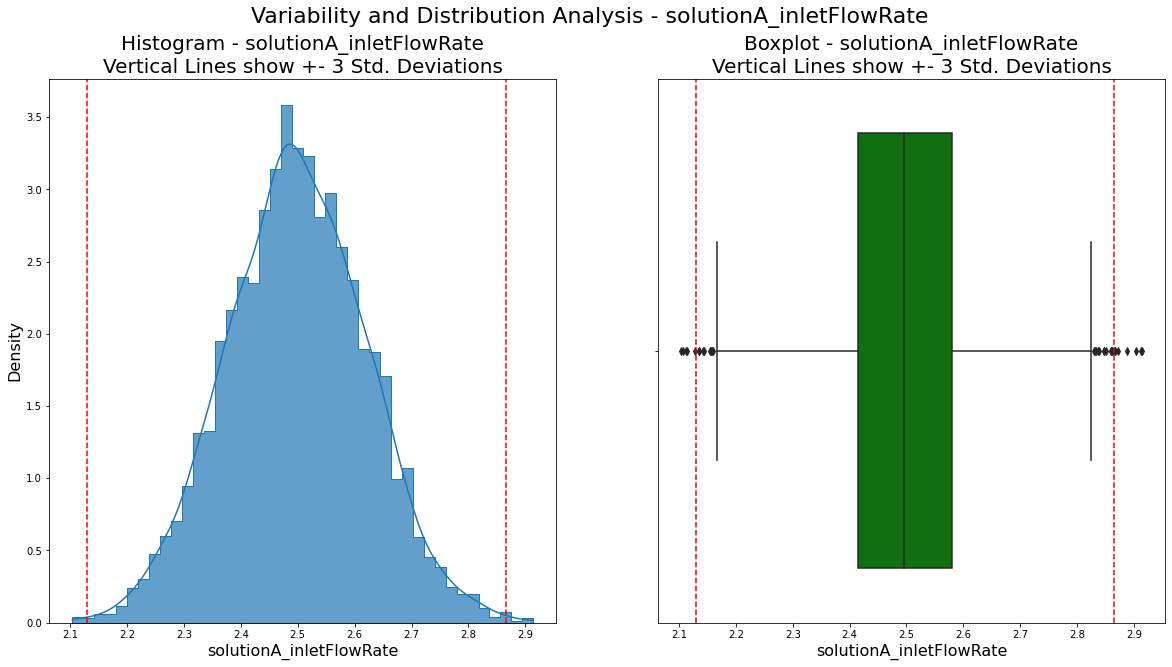

In [7]:
var_name = data.columns[0]
hist_boxplot(data, var_name)

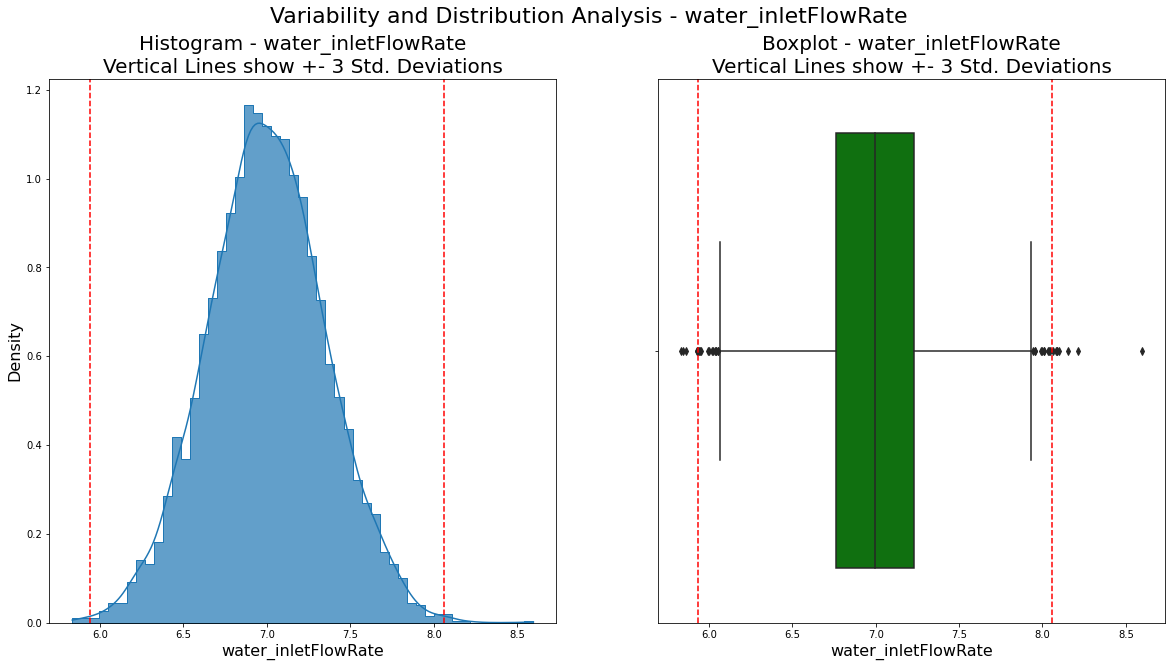

In [8]:
var_name = data.columns[1]
hist_boxplot(data, var_name)

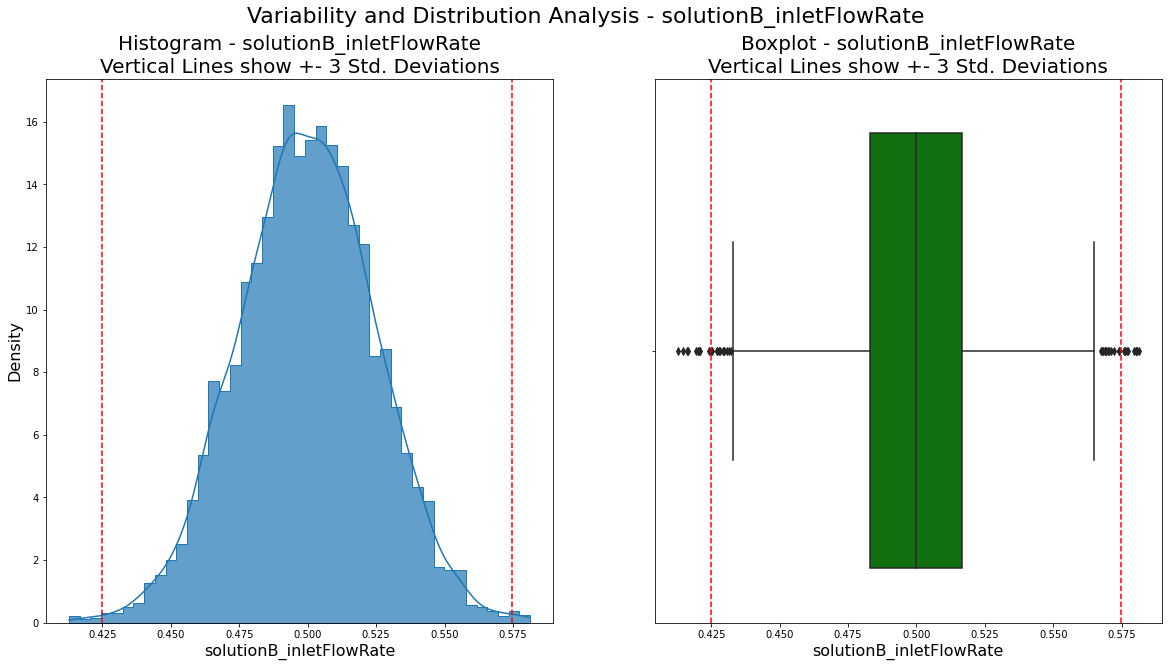

In [9]:
var_name = data.columns[2]
hist_boxplot(data, var_name)

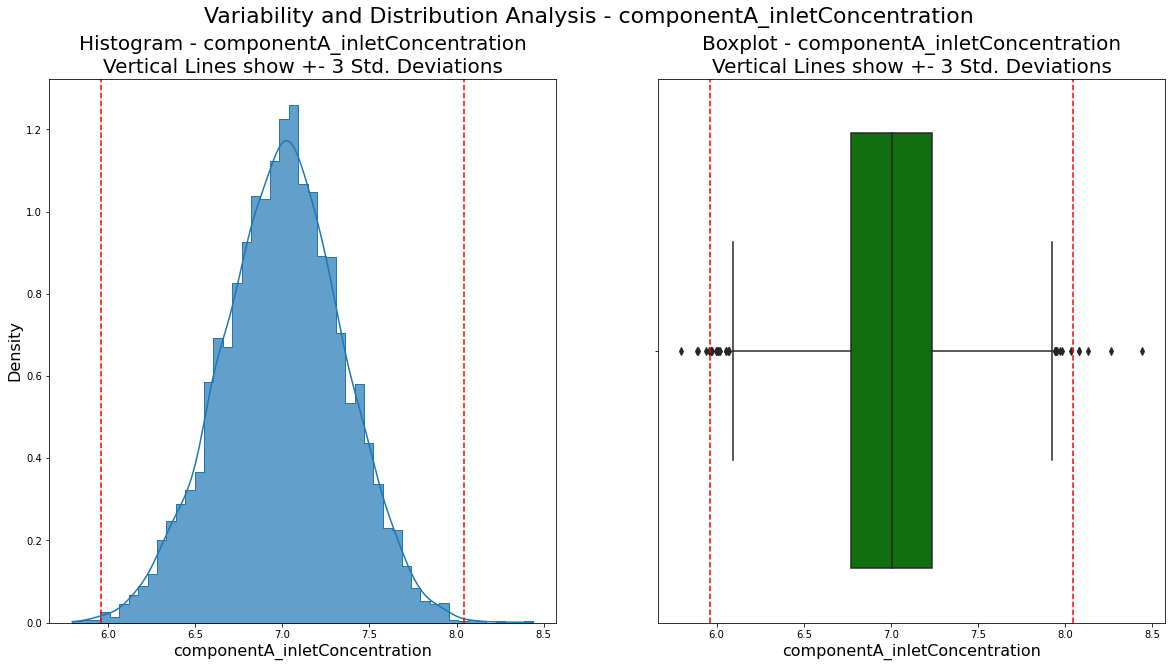

In [10]:
var_name = data.columns[3]
hist_boxplot(data, var_name)

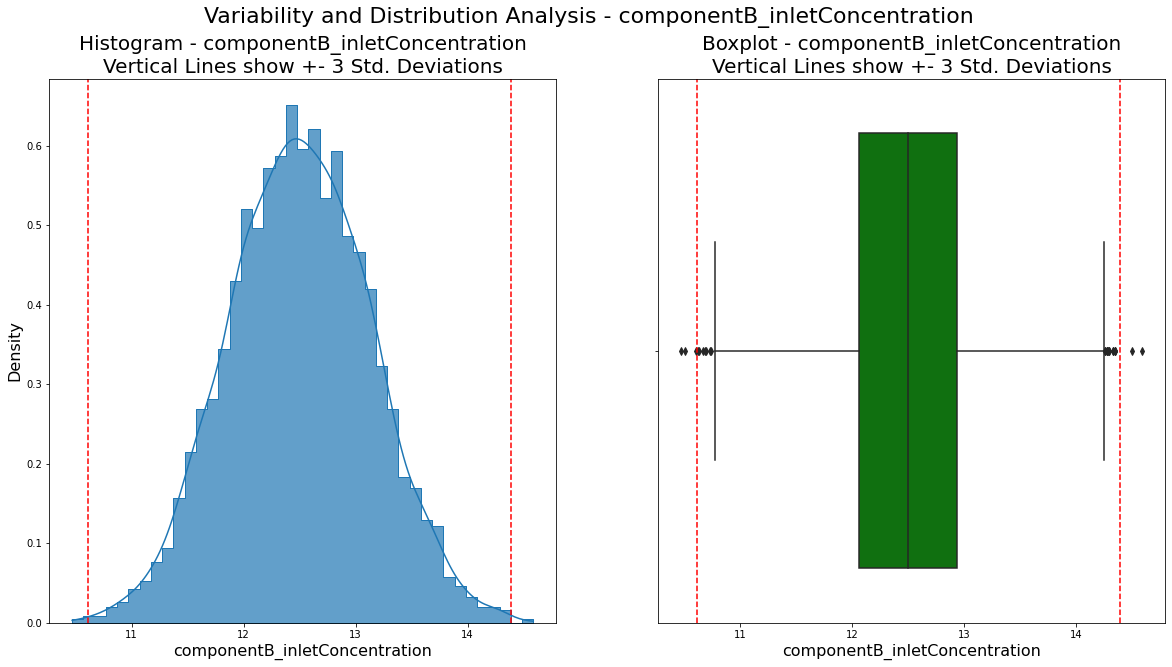

In [11]:
var_name = data.columns[4]
hist_boxplot(data, var_name)

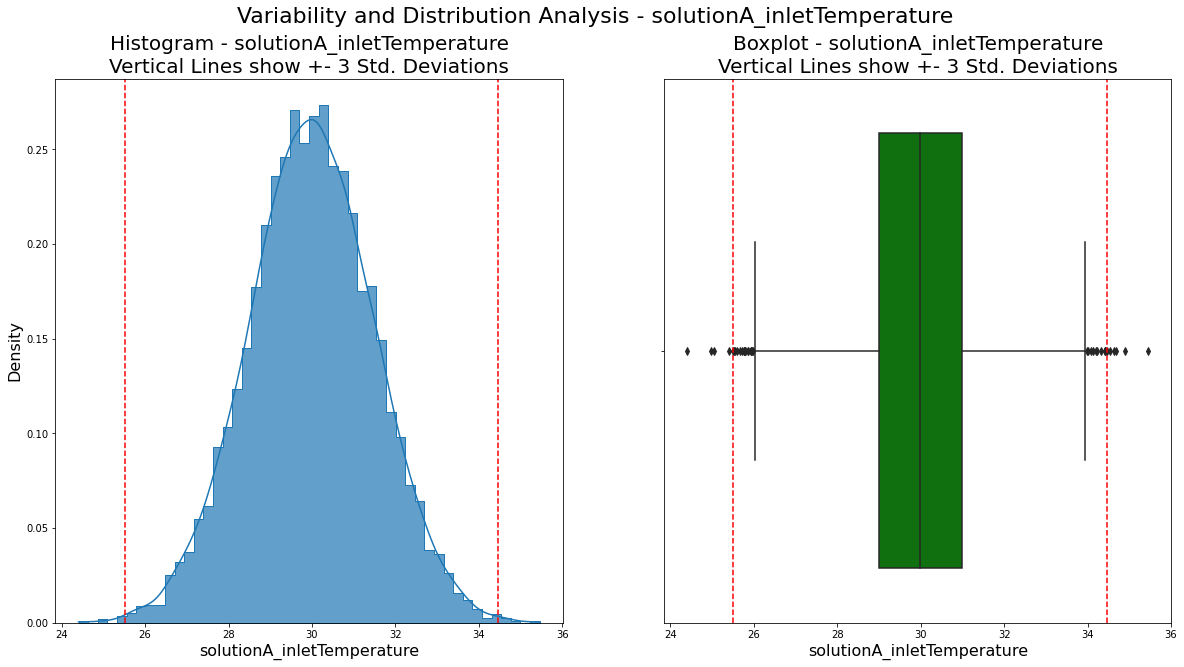

In [12]:
var_name = data.columns[5]
hist_boxplot(data, var_name)

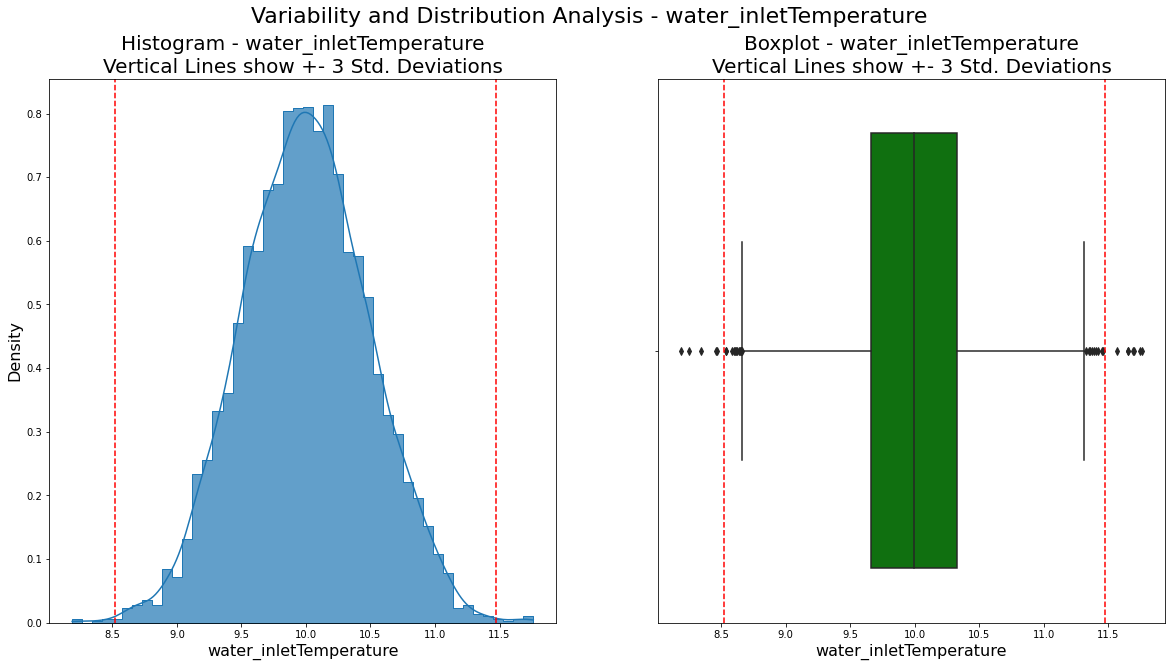

In [13]:
var_name = data.columns[6]
hist_boxplot(data, var_name)

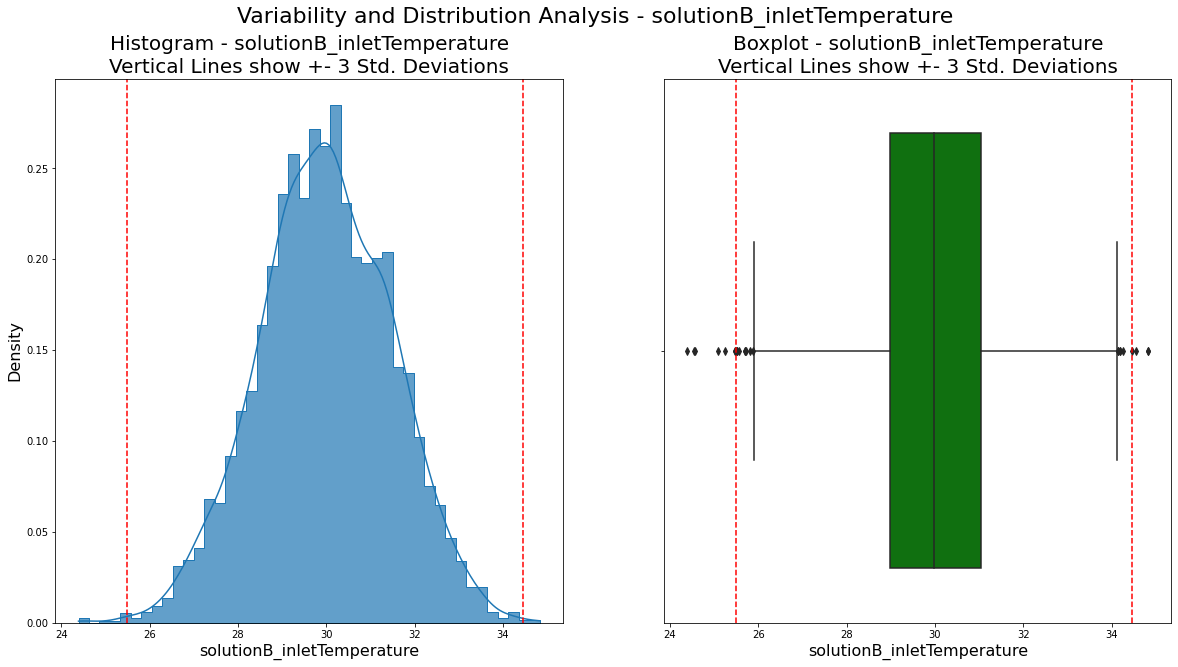

In [14]:
var_name = data.columns[7]
hist_boxplot(data, var_name)

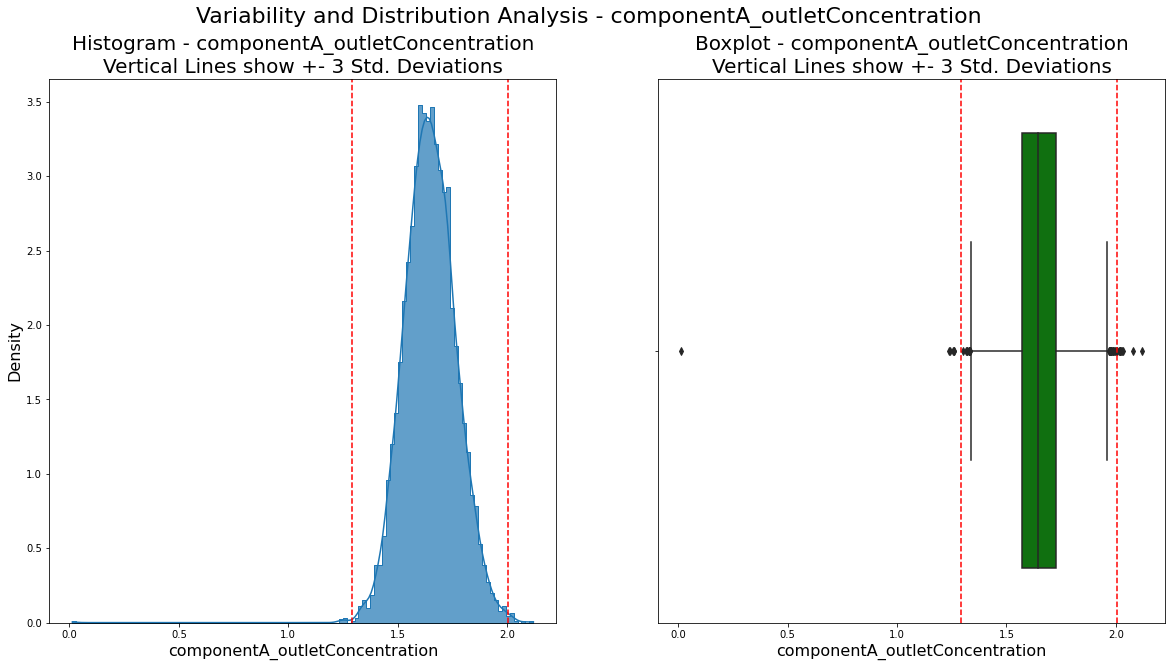

In [15]:
var_name = data.columns[8]
hist_boxplot(data, var_name)

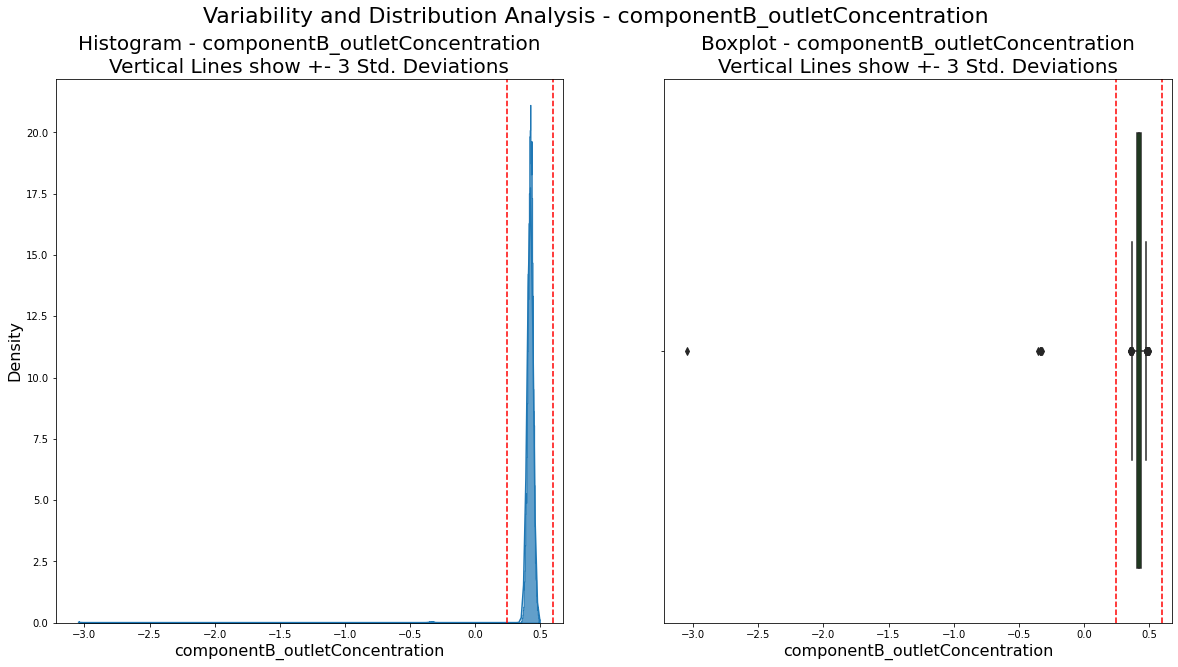

In [16]:
var_name = data.columns[9]
hist_boxplot(data, var_name)

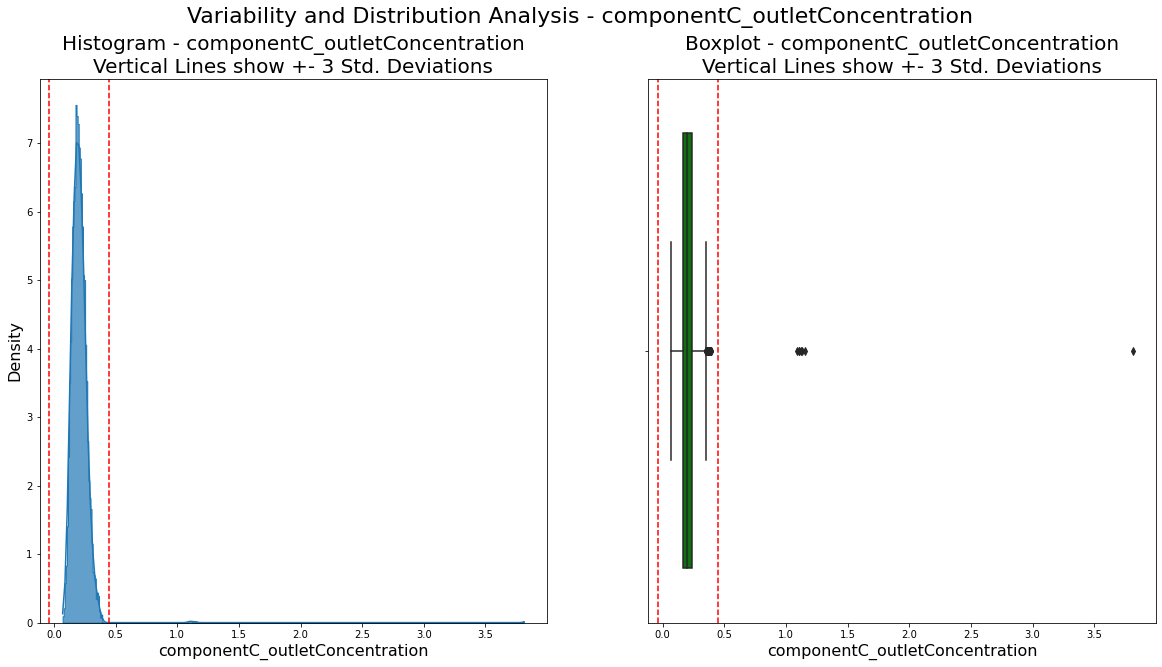

In [17]:
var_name = data.columns[10]
hist_boxplot(data, var_name)

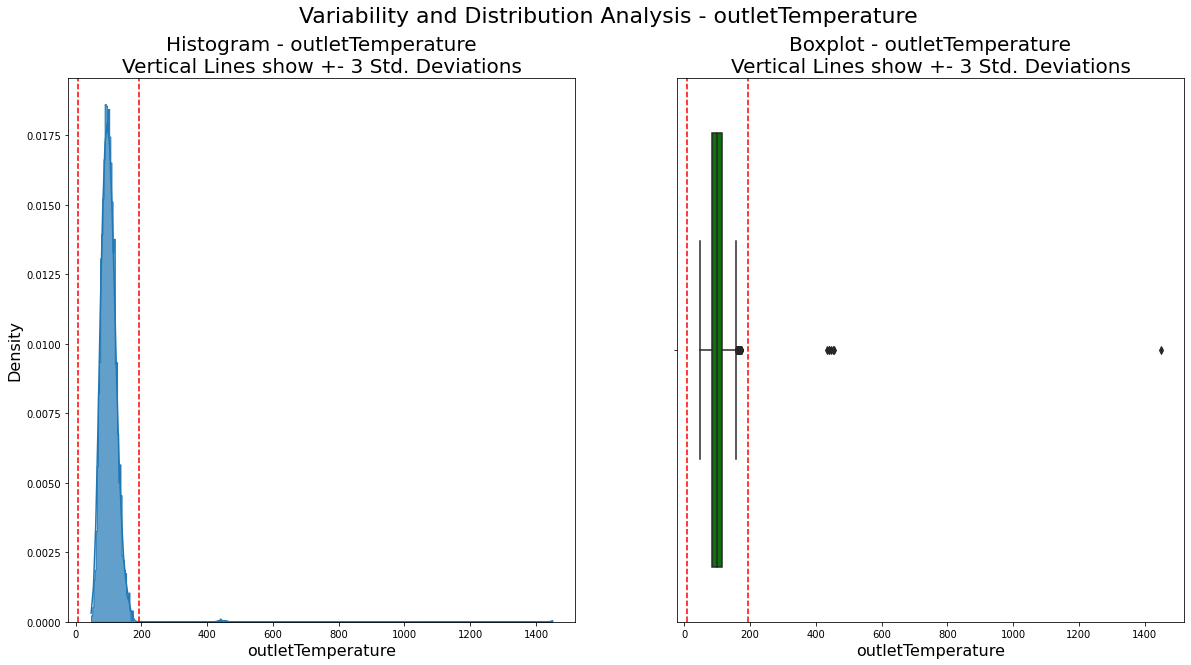

In [18]:
var_name = data.columns[11]
hist_boxplot(data, var_name)

The distribution analysis showed that all variables have outliers values. Some of the variables showed outlier values that do not reflect usual process conditions, promoting a distribution distortion.

It's necessary to clean the data. For this study study, the team decided to get rid of outlier values, because they represent measure errors.

In [19]:
def data_treatment(data, var_name):

  # this function automates data outlier cleaning

  # parameters for elimination 
  avg = data[var_name].mean()
  sd = data[var_name].std()

  # upper and lower limits
  sup = avg + 3*sd
  inf = avg - 3*sd

  # original number of lines
  n_before = data.shape[0]

  # data cleaning 
  data = data.loc[(data[var_name] >= inf) & (data[var_name] <= sup)]

  # final number of lines
  n_after = data.shape[0]

  print('Original Dataset: %d linhas'%n_before)
  print('Cleaned Dataset: %d linhas'%n_after)
  print('Reduction: %.2f %%'%((n_before-n_after)*100/n_before))

  return data

Original Dataset: 5000 linhas
Cleaned Dataset: 4988 linhas
Reduction: 0.24 %


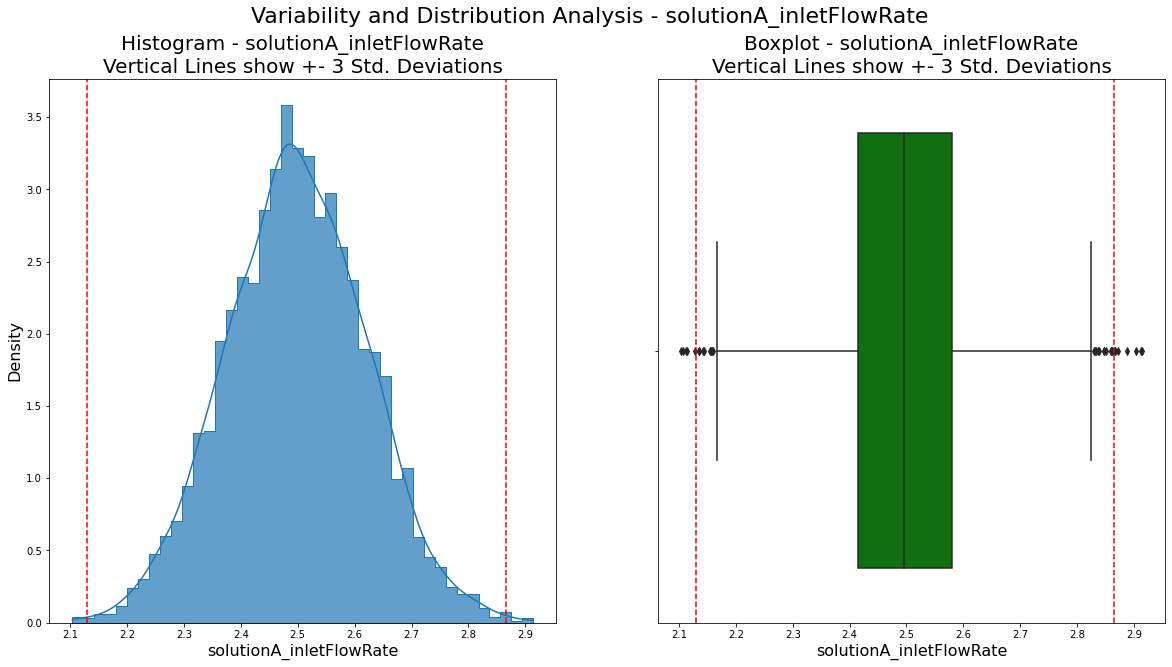

In [20]:
var_name = data.columns[0]
data_t = data_treatment(data, var_name)
hist_boxplot(data, var_name)

In [21]:
#once tested, the function is applied to all other columns of the dataset
columns_list = data.columns

for column in columns_list:
  data_t = data_treatment(data_t, column)

Original Dataset: 4988 linhas
Cleaned Dataset: 4988 linhas
Reduction: 0.00 %
Original Dataset: 4988 linhas
Cleaned Dataset: 4974 linhas
Reduction: 0.28 %
Original Dataset: 4974 linhas
Cleaned Dataset: 4955 linhas
Reduction: 0.38 %
Original Dataset: 4955 linhas
Cleaned Dataset: 4945 linhas
Reduction: 0.20 %
Original Dataset: 4945 linhas
Cleaned Dataset: 4940 linhas
Reduction: 0.10 %
Original Dataset: 4940 linhas
Cleaned Dataset: 4929 linhas
Reduction: 0.22 %
Original Dataset: 4929 linhas
Cleaned Dataset: 4917 linhas
Reduction: 0.24 %
Original Dataset: 4917 linhas
Cleaned Dataset: 4906 linhas
Reduction: 0.22 %
Original Dataset: 4906 linhas
Cleaned Dataset: 4893 linhas
Reduction: 0.26 %
Original Dataset: 4893 linhas
Cleaned Dataset: 4889 linhas
Reduction: 0.08 %
Original Dataset: 4889 linhas
Cleaned Dataset: 4870 linhas
Reduction: 0.39 %
Original Dataset: 4870 linhas
Cleaned Dataset: 4866 linhas
Reduction: 0.08 %


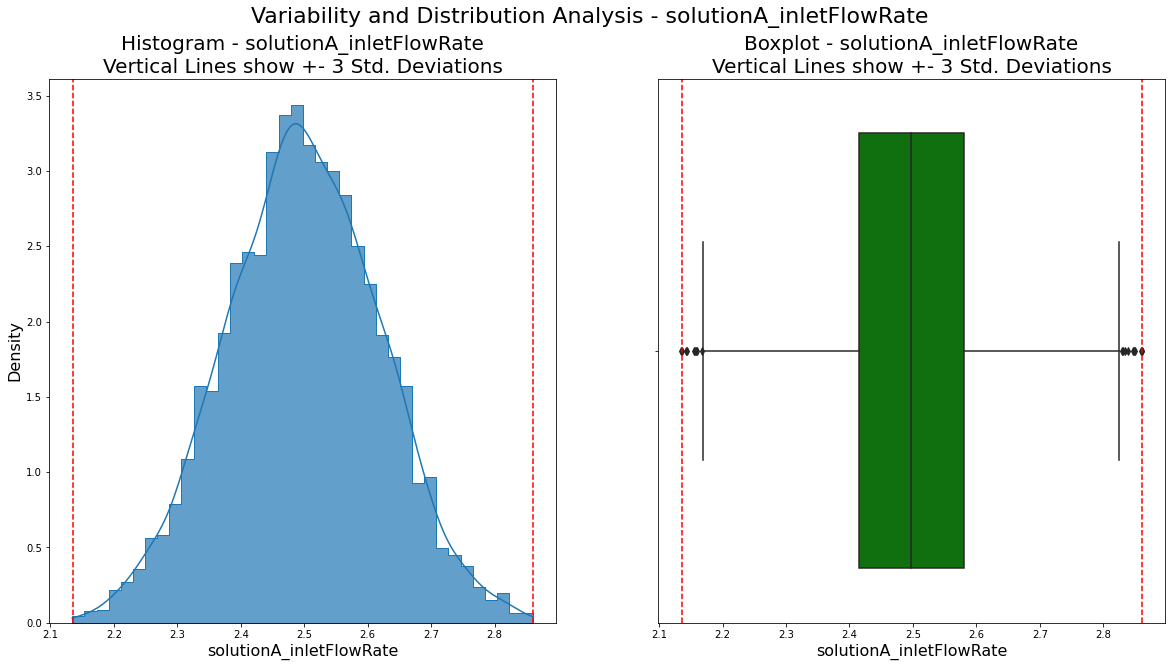

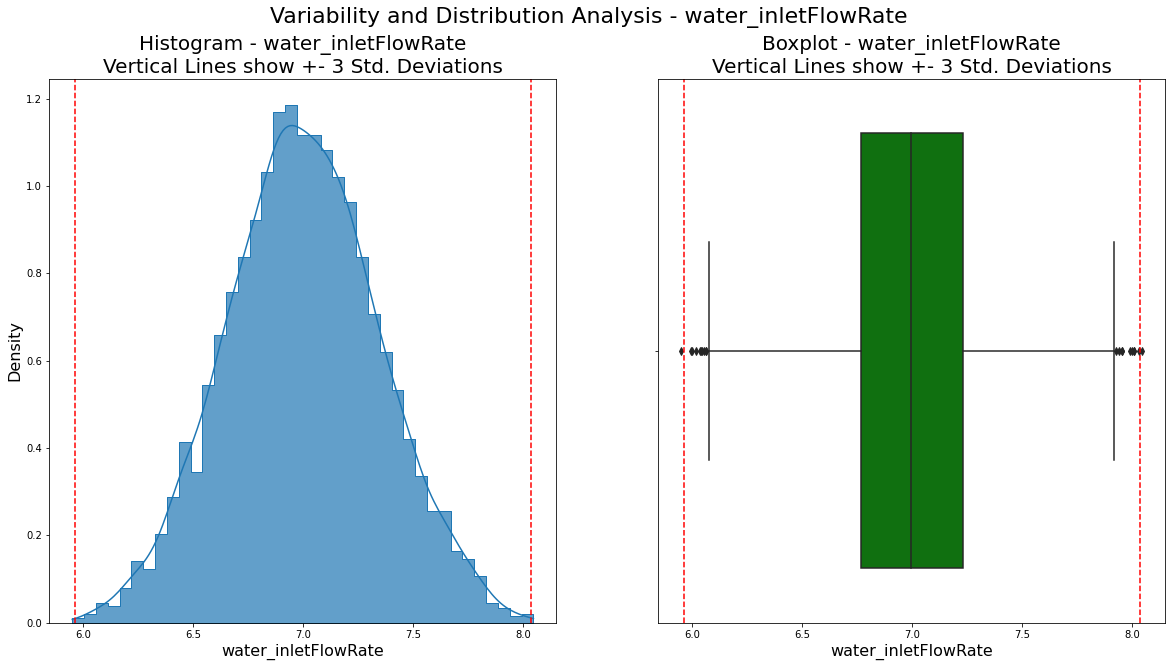

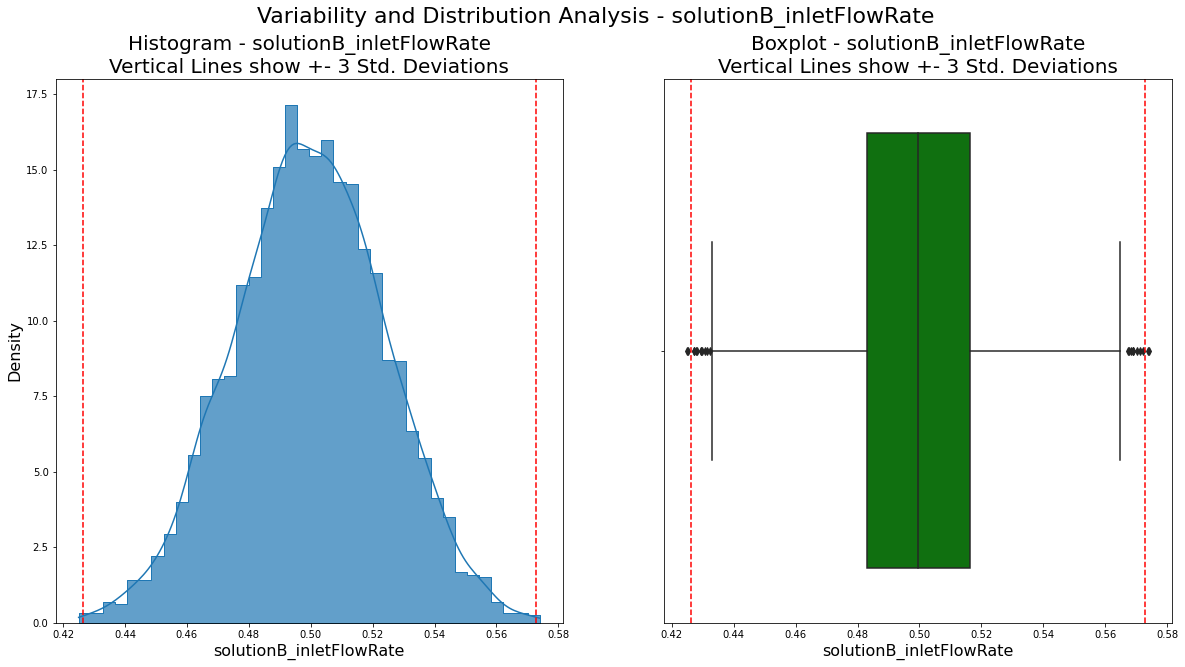

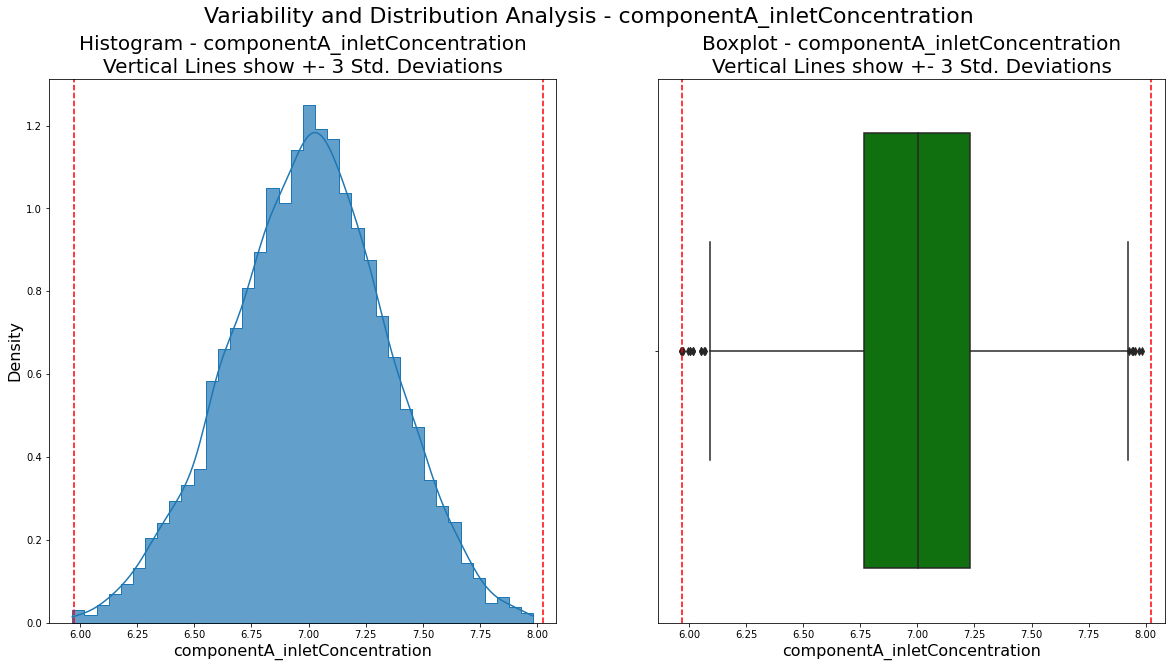

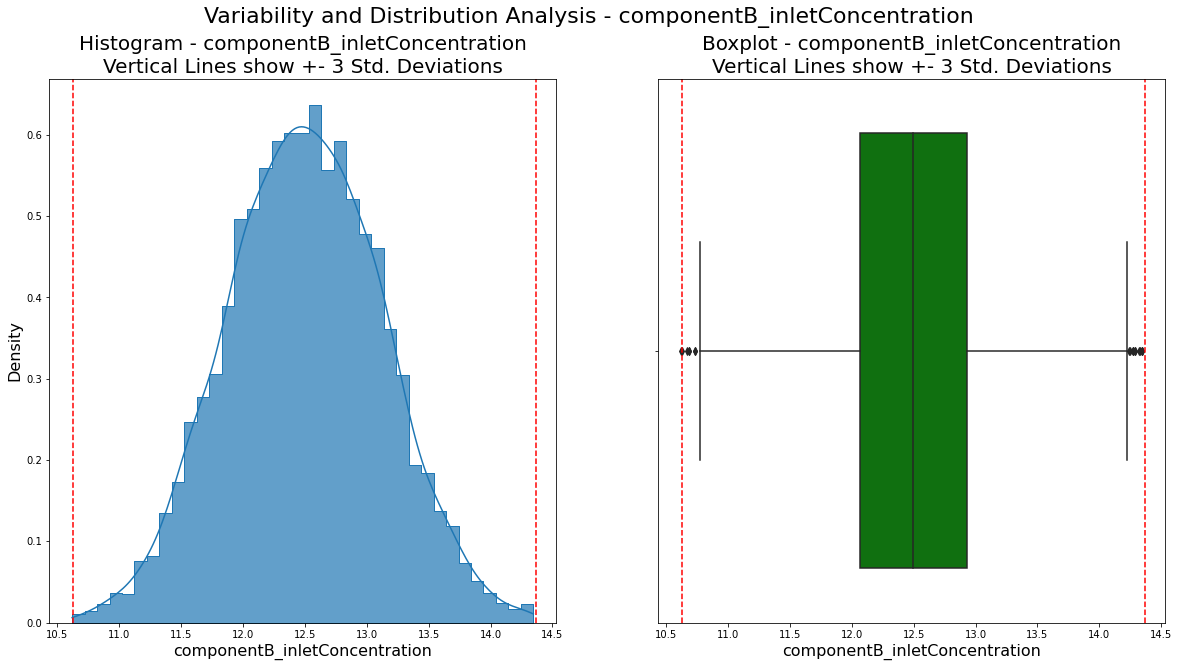

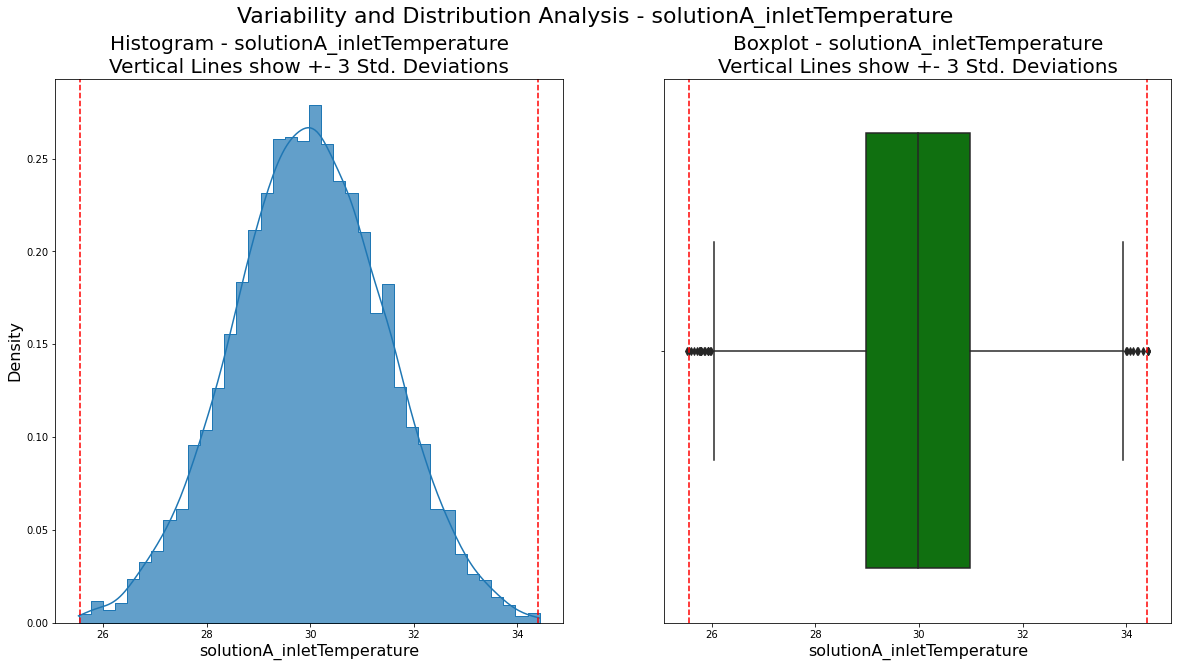

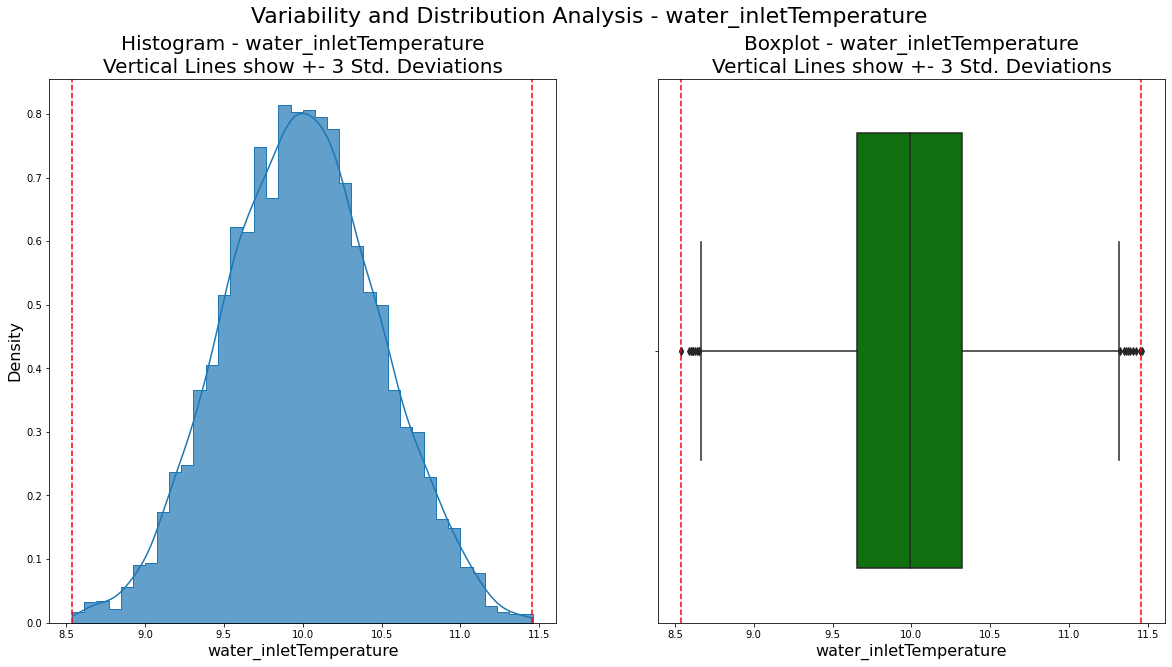

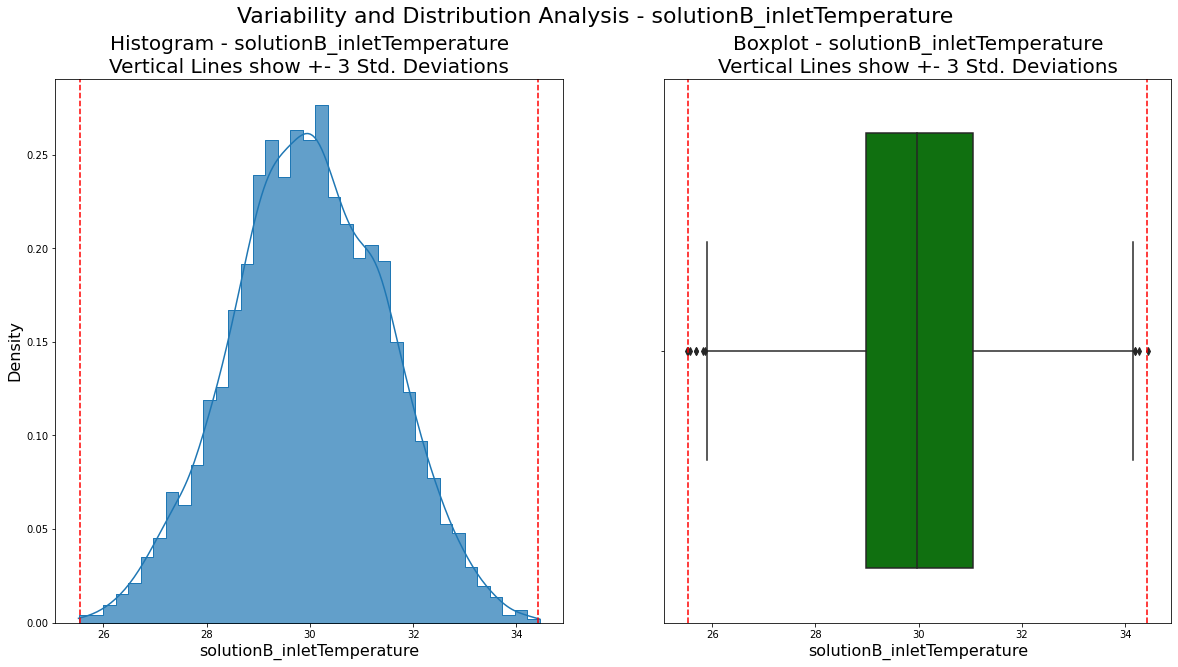

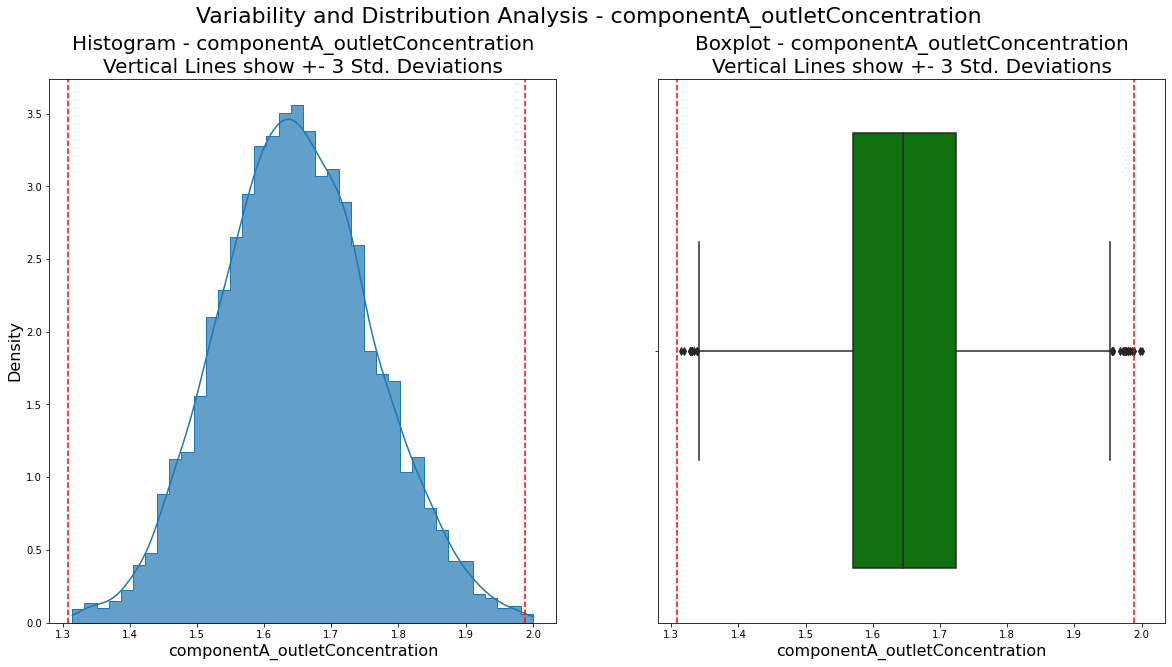

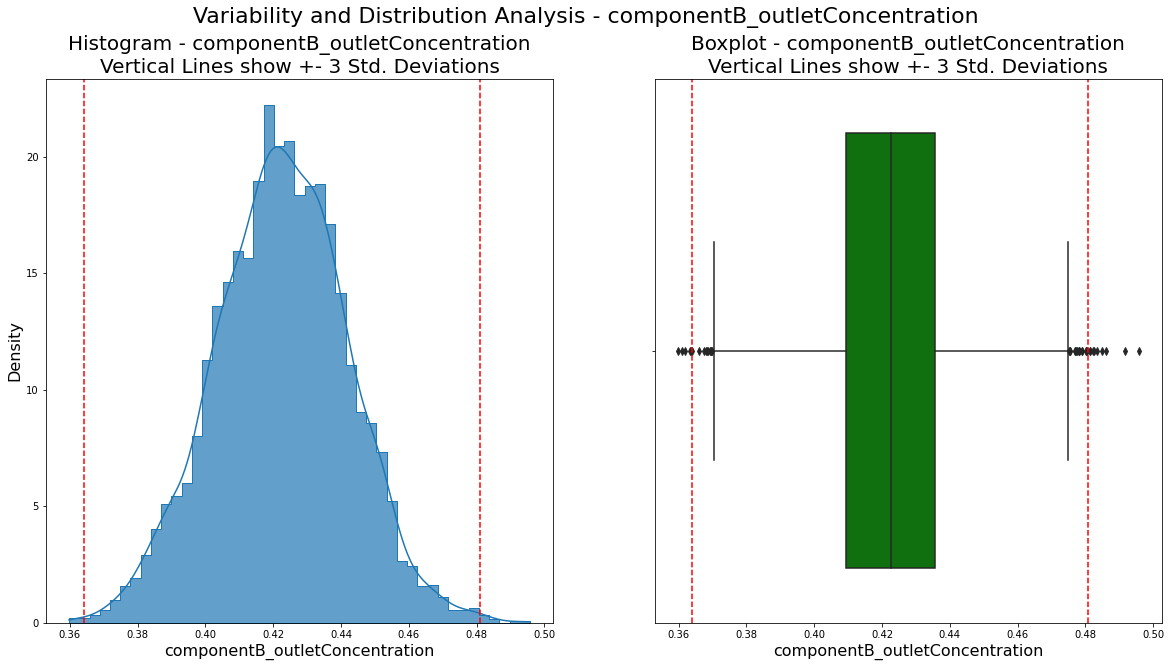

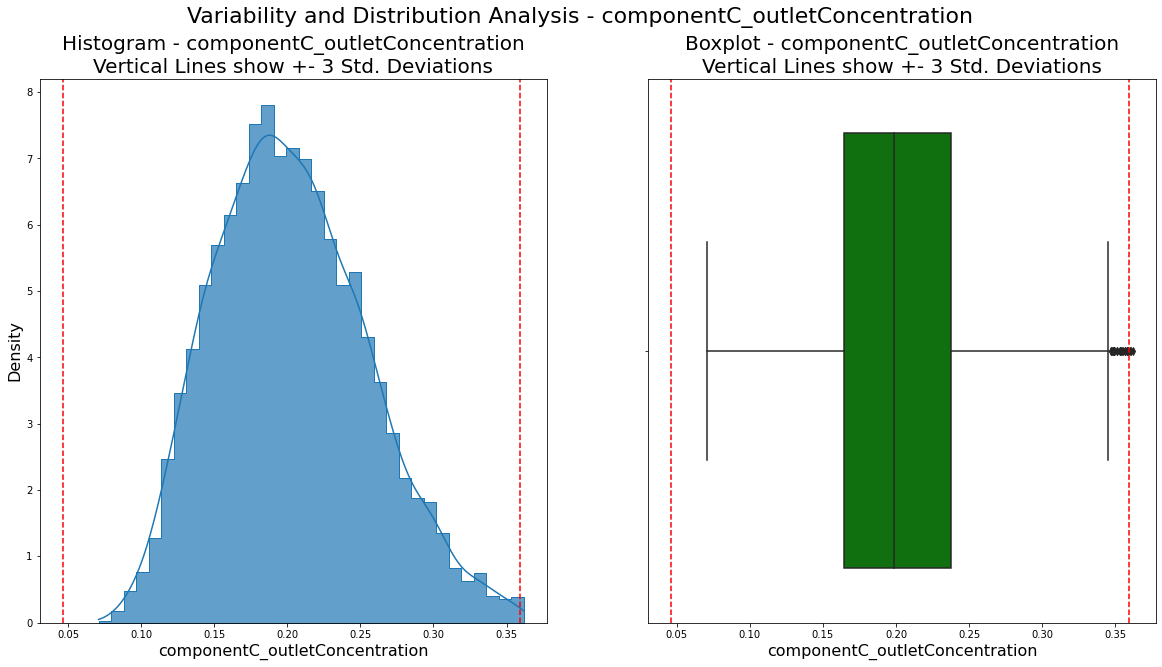

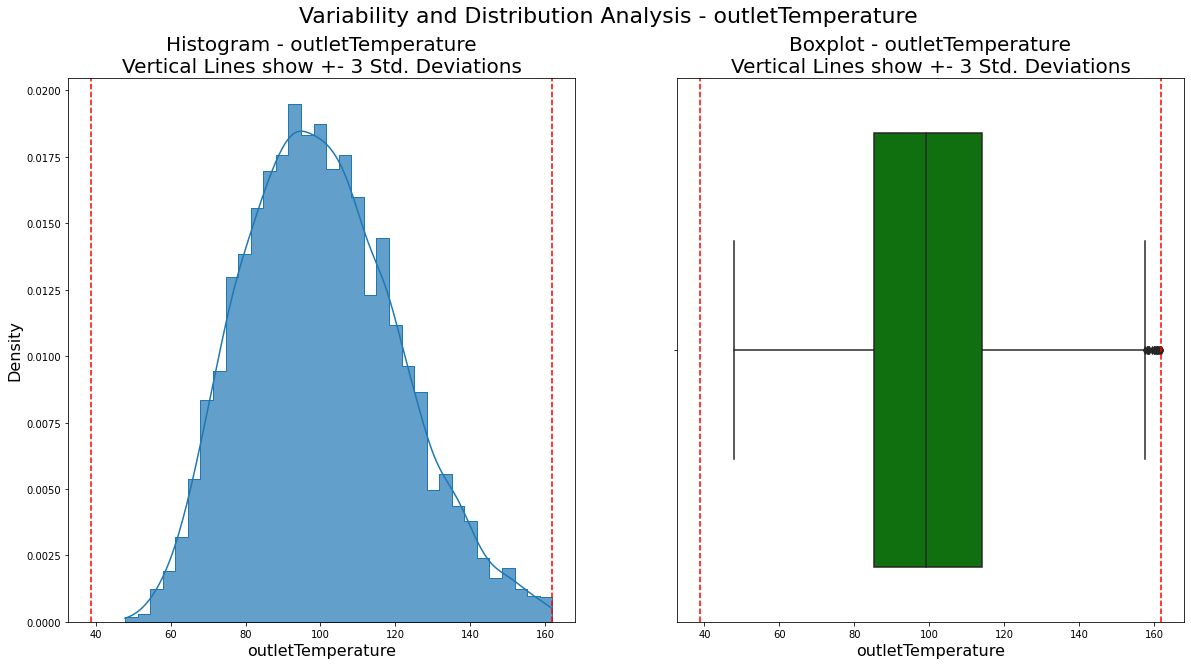

In [22]:
# checking the modifications' effect
for column in columns_list:
  hist_boxplot(data_t, column)

In [23]:
# total reduction of dataset
print('Original Dataset: %d linhas'%data.shape[0])
print('Cleaned Dataset: %d linhas'%data_t.shape[0])
print('Total Reduction: %.2f%%'%((data.shape[0]-data_t.shape[0])*100/data.shape[0]))

Original Dataset: 5000 linhas
Cleaned Dataset: 4866 linhas
Total Reduction: 2.68%


The cleaning of data produced a more symmetric dataset, since all variables distributions present a bell shaped behavior

Next step is to understand the correlation between process variables.

<AxesSubplot:>

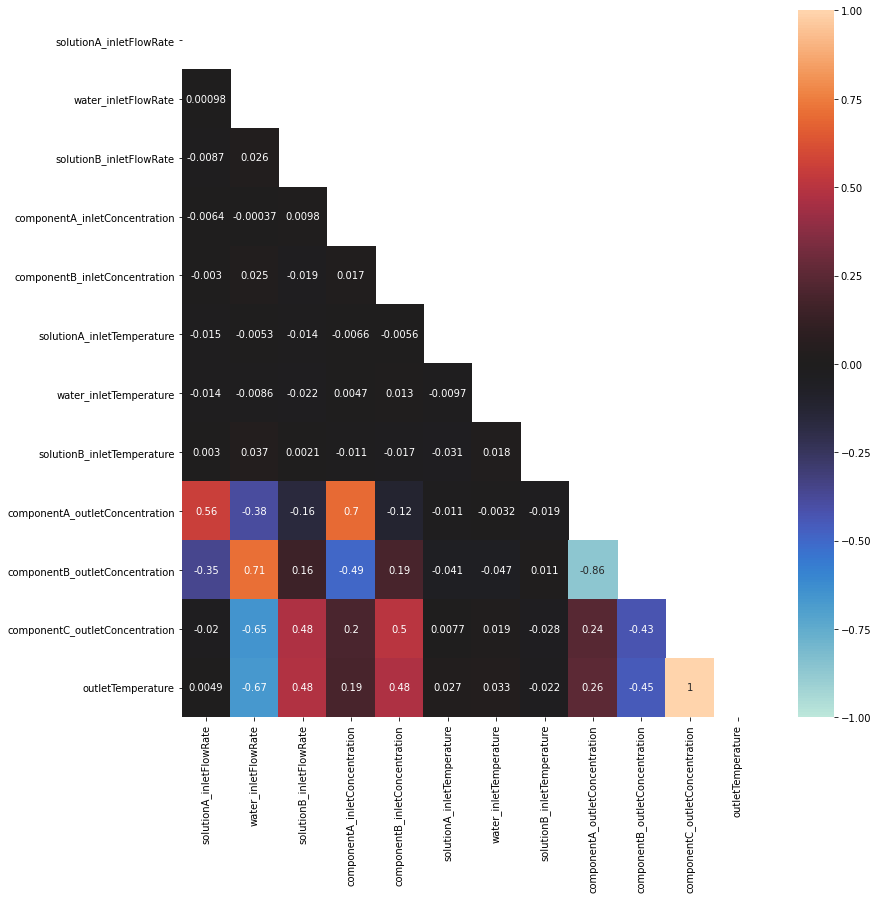

In [24]:
# correlation matrix calculation
corr = data_t.corr()

# heatmap correlation mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# plotting correlation heatmap
plt.figure(figsize = (13,13))
sns.heatmap(corr, mask=mask, vmax=1, center=0, vmin = -1, annot = True)

The correlation matrix shows that the input variables are statistically independent from each other, since the correlation coefficients are next to zero.

However, there are significant correlations between input variables and output variables, which was expected because of the physico-chemical principia that drive chemical processes.

It is also necessary to understang how each variable correlates itself along with its pairs, using scatterplots. A correlation threshold should be applied to limit the analysis to the most promising correlations.


### **2.1. Component A Outlet Concentration** 

In [25]:
# minimum correlation threshold
thres = 0.2
elec_var = 'componentA_outletConcentration'

def scatter_analysis(data, elec_var, thres):

  # this function performs scatterplot analysis between the selected variable and
  # the most promising correlated variables.

  # correlation matrix calculation and column selection
  corr_mat = pd.DataFrame(data.corr()[elec_var].reset_index())
  corr_mat.columns = ['var','corr']

  # selection of variables that surpass minimum correlation threshold
  elec_corr = list(corr_mat.loc[abs(corr_mat['corr'])>thres]['var'])

  # scatterplot building
  ncol = 3
  nlin = len(elec_corr)//3 + 1
  i = 1

  plt.figure(figsize = (15,13))
  plt.subplots_adjust(wspace = 0.5, hspace = 0.3)
  for col in elec_corr:
    plt.subplot(nlin, ncol, i)
    plt.scatter(x = col, y = elec_var, marker = '.', data = data, color = 'black')
    plt.xlabel(col)
    plt.ylabel(elec_var)
    plt.grid()

    if i == 2:
      plt.title('Scatterplot - ' + elec_var + 
                '\nMinimum Correlation Threshold: ' + str(thres) + '\n',
                fontsize = 24)

    i += 1

  plt.show()

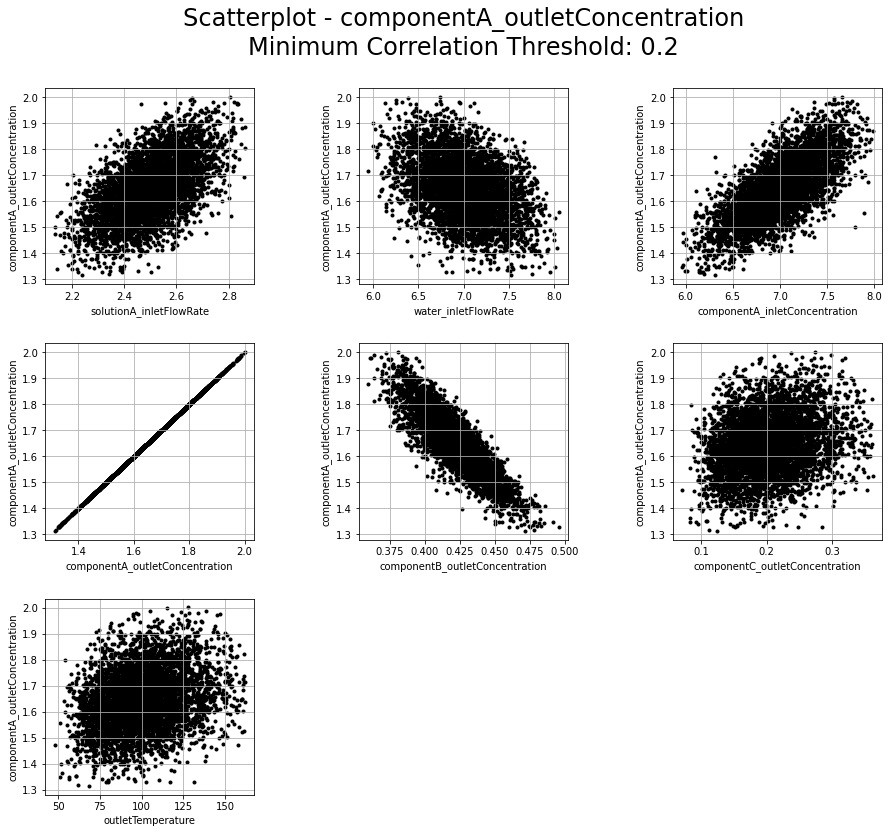

In [26]:
thres = 0.2
elec_var = 'componentA_outletConcentration'
scatter_analysis(data_t, elec_var, thres)

The following conclusions can be drawn from scatterplot of component A:

- increasing the component A inlet flowrate or the component A inlet concentration promotes an increase in component A outlet concentration
- increasing the water inlet flowrate, a dilution of the system is expected and hence, the outlet concentration of component A is expected to decrease
- there is a colinearity with the outlet concentration of component B, because greater levels of component A at outlet indicate minor degrees of advance of the reaction and hence, major concentration of component B. Also, it is expected to correlated with minor levels of component C and also minor outlet temperatures.


### **2.2. Component B Outlet Concentration**


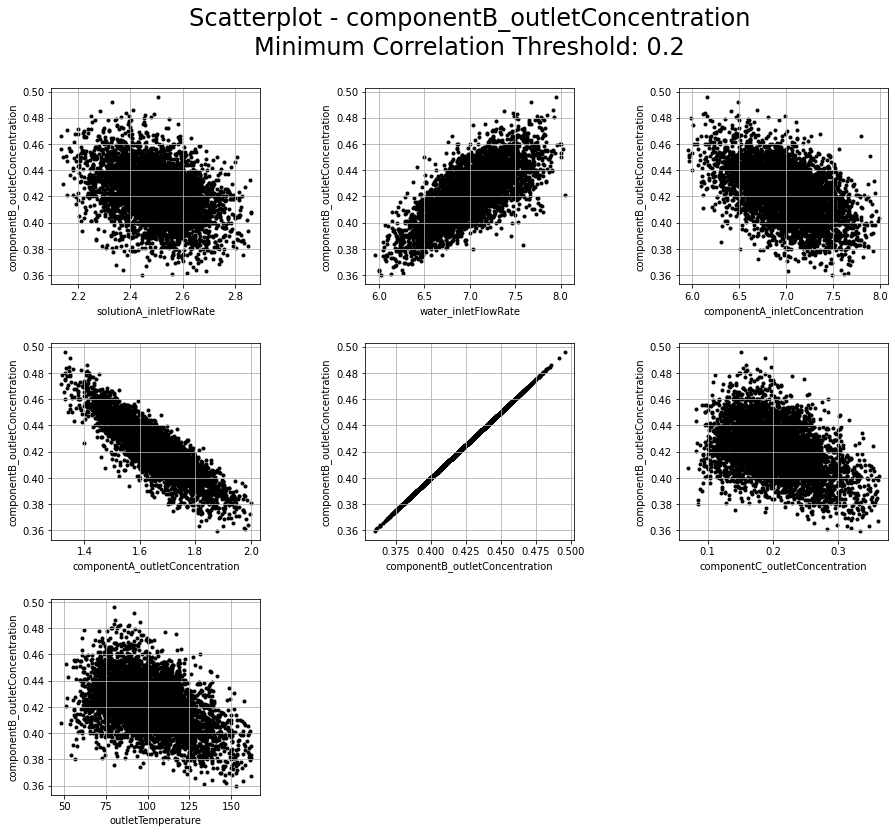

In [27]:
thres = 0.2
elec_var = 'componentB_outletConcentration'
scatter_analysis(data_t, elec_var, thres)

- the increase of component A inlet flowrate promotes the decreasing of component B outlet concentration, due to the increase in reaction advance
- the increase of water flow rate promotes the dilution of all system and then, the decrease of reaction rate and thus, it increases the concentration of component B at outlet
- there is a colinearity with the concentration of component C and with the outlet stream temperature. If more component B is present at outlet stream, the the reaction rate is expected to be lower and then thus, minor concentrations of C are expected along with lower temperatures


### **2.3. Component C Outlet Concentration**

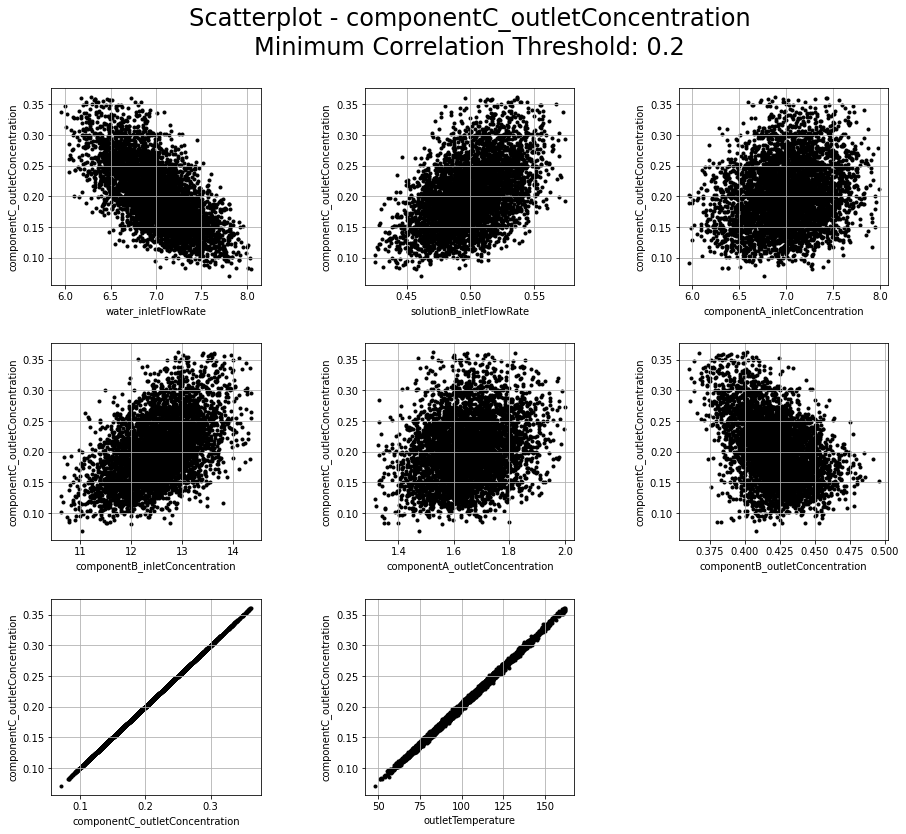

In [28]:
thres = 0.2
elec_var = 'componentC_outletConcentration'
scatter_analysis(data_t, elec_var, thres)

- increasing the water inlet flow rate promotes the decreasing of component C outlet concentration due to dilution and hence, to the decrease of reaction rate.
- both inlet flow rate and concentration of component B increases affect positively the concentration of C at outlet, because both increase the reaction rate (only source of C in this system)
- there is a positive colinearity with component A outlet concentration, because the addition of component A in the reactor promotes the increase of reaction rate
- there also a positive colinearity correaltion with the outlet concentration of component B, because of the previously drawn conclusion. If the concentration of A increases in the reactor, more component B is consumed in the reaction and a lesser concentration of B is expected at the outlet stream. Also, the bigger production of C means a bigger release of energy (the reaction is exothermic) and also the concentration of C is strongly correlated with outler temperature.


## **3. Statistical Process Control Analysis**

Statistical process control is tool that helps the understanding if a process is under control, from the point of view of statistics. We say that a process is under control if the variability observed are only inside the statistical limits, which represent intrinsic natural variability.

If the observed variablity are bigger than those limits, than it is said that the process are influenced by *unnatural* causes. This means that there are external factors that affect process behavior.

In this study, we simulate the acquisition of quality related data for each 15 minutes. Hence, for each hour of production, there are 4 samples.


### **3.1. Component A - Outlet Concentration**

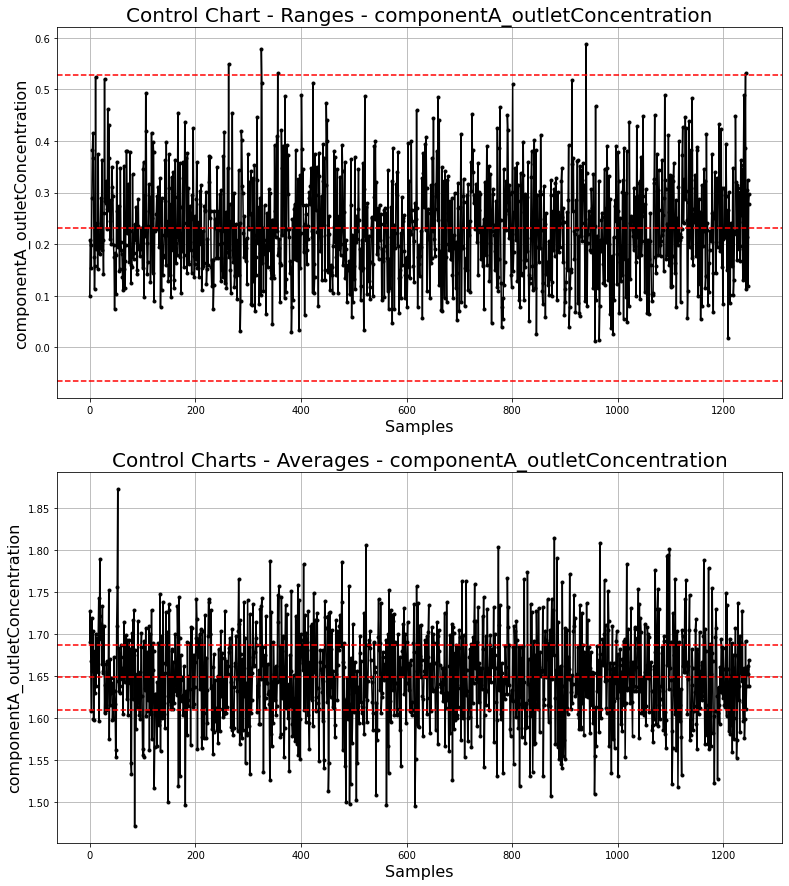

In [29]:
var_name = 'componentA_outletConcentration'

results_A_out = control_chart(data_t, var_name, n = 4)


### **3.2. Component B - Outlet Concentration**

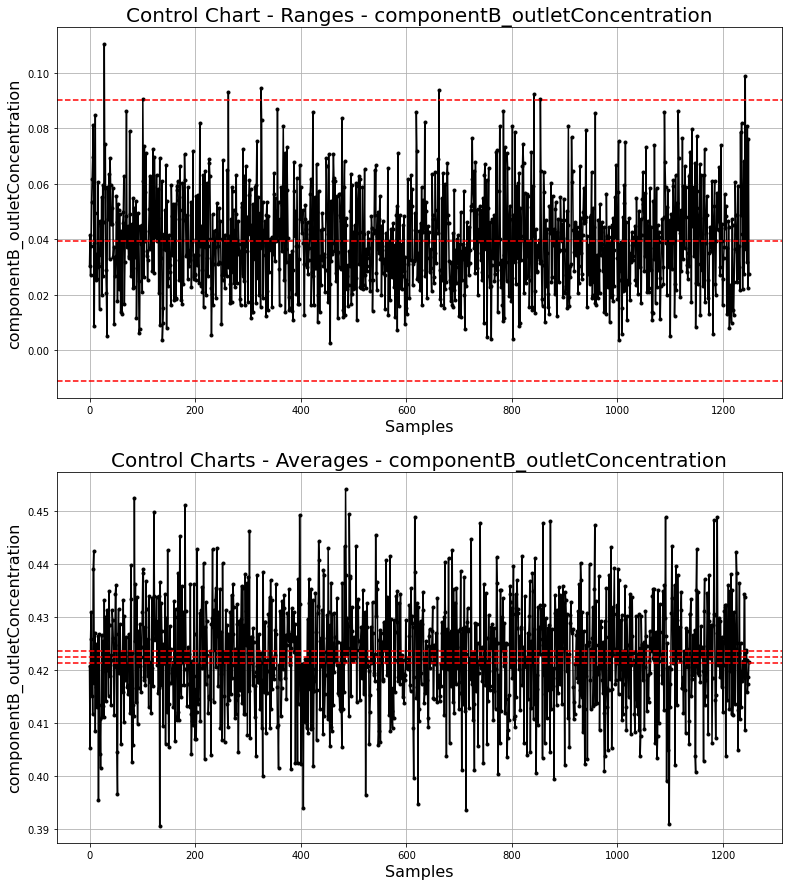

In [30]:
var_name = 'componentB_outletConcentration'

results_B_out = control_chart(data_t, var_name, n = 4)


### **3.3. Component C - Outlet Concentration**

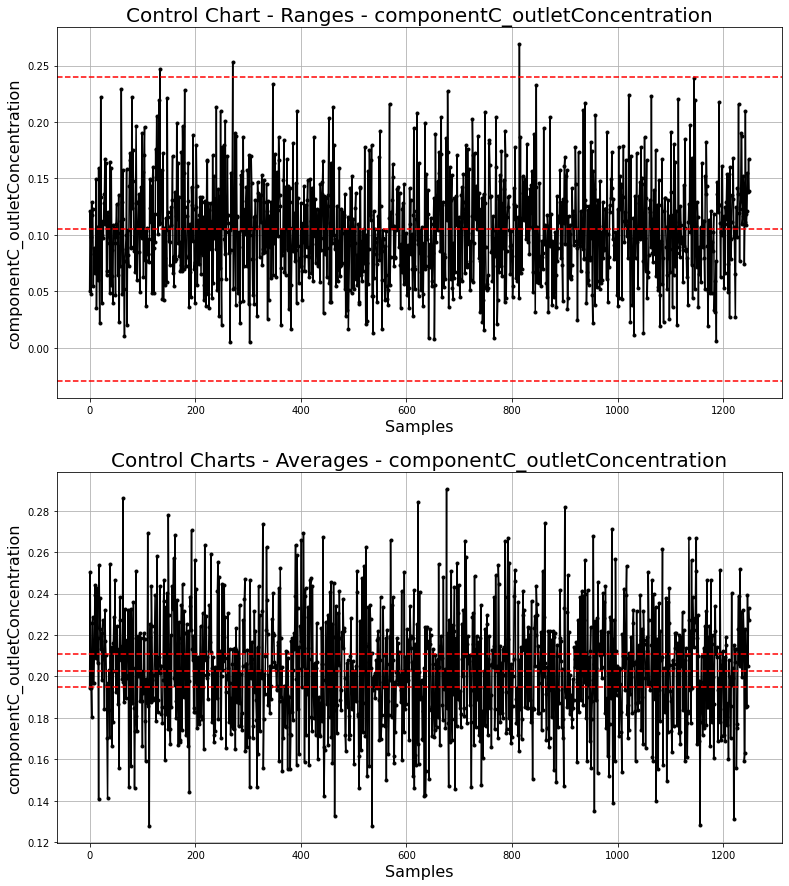

In [31]:
var_name = 'componentC_outletConcentration'

results_C_out = control_chart(data_t, var_name, n = 4)

As we can see, the three output variables evaluated present great variablity.  There are many points that are above or below the statistical limits of control. This corroborates the thesis from the beginning of the study: the evaluated process is out of control.

A non-controlled process is bad for the business, because it is impossible to control the quality of the products leaving such reactor. Moreover, if there are downstream units, their operation will surely be harmed.

Another impact that deserves attention is the safety on operating non-controlled processes. Since the concentration of component C is strongly correlated with temperature, there is no warranty that the temperature of outlet stream will not achieve dangerous levels.

Thus it is desired that the model for anomaly detection should detect and deal with the combinations of input variables that produce out-of-control points.

## **4. Modelling and Preprocessing Strategy**


Due to the high correlation with component C outlet concentration, this study will not look to temperature control. We will create three anomaly detection models enable process instability prediction.

### **4.1. New Variables Creation**

In this step, a flag variable will be created to indicate if the instance in or out of statistical control.

0 - for data inside statistical process control
1 - for data above the maximum statistical process control
2 - for data below the minimul statistical process control


In [32]:
# new variable creation
def new_feat(data, keys_values, col_name):

  # dictionary value extraction
  LIC_X = keys_values['LIC_X']
  LSC_X = keys_values['LSC_X']

  # creation of new flag variable base on statistical control situation
  data['CONTROL'] = int(0)
  data.loc[data[col_name] > LSC_X,'CONTROL'] = int(1)
  data.loc[data[col_name] < LIC_X,'CONTROL'] = int(2)

  # reseting indexes
  data = data.reset_index()
  data.drop(['index'], axis = 1, inplace = True)

  return data

In [33]:
# data treatment for component A outlet concentration
col_name = 'componentA_outletConcentration'
to_drop = ['componentB_outletConcentration', 'componentC_outletConcentration', 
           'outletTemperature']
dataA = data_t.copy()
dataA.drop(to_drop, axis = 1, inplace = True)

dataA = new_feat(dataA, results_A_out, col_name)
dataA['CONTROL'].value_counts()

2    1821
1    1756
0    1289
Name: CONTROL, dtype: int64

In [34]:
# data treatment for component B outlet concentration
col_name = 'componentB_outletConcentration'
to_drop = ['componentA_outletConcentration', 'componentC_outletConcentration','outletTemperature']
dataB = data_t.copy()
dataB.drop(to_drop, axis = 1, inplace = True)

dataB = new_feat(dataB, results_B_out, col_name)
dataB['CONTROL'].value_counts()

1    2326
2    2301
0     239
Name: CONTROL, dtype: int64

In [35]:
# data treatment for component C outlet concentration
col_name = 'componentC_outletConcentration'
to_drop = ['componentA_outletConcentration', 'componentB_outletConcentration', 'outletTemperature']
dataC = data_t.copy()
dataC.drop(to_drop, axis = 1, inplace = True)

dataC = new_feat(dataC, results_C_out, col_name)
dataC['CONTROL'].value_counts()

2    2273
1    2030
0     563
Name: CONTROL, dtype: int64

### **4.2. Train-test splitting**

Train-test sets splitting will be done using stratified sampling, using the created flag variable. Stratified samplig is used to preserve categories distributions between train and test sets.

In [36]:
# stratified sampling to preserve category distribution between train and test samples
def dataset_split(data, split_var, to_drop_list):

  # stratified split
  split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = RANDOM_SEED)

  # split application
  for train_index, test_index in split.split(data, data[split_var]):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

  # splitting into predictors and target values
  y_train = train_set[split_var]
  x_train = train_set.drop(to_drop_list + [split_var], axis = 1)

  y_test = test_set[split_var]
  x_test = test_set.drop(to_drop_list + [split_var], axis = 1)

  return x_train, x_test, y_train, y_test  

In [37]:
x_trainA, x_testA, y_trainA, y_testA = dataset_split(dataA, 'CONTROL', ['componentA_outletConcentration'])
x_trainB, x_testB, y_trainB, y_testB = dataset_split(dataB, 'CONTROL', ['componentB_outletConcentration'])
x_trainC, x_testC, y_trainC, y_testC = dataset_split(dataC, 'CONTROL', ['componentC_outletConcentration'])

### **4.3. Feature Scaling**

#### 4.2.1. Component A Outlet Concentration

In [38]:
# scaler definition
scalerA = StandardScaler()

# scaler fitting and application
scalerA = scalerA.fit(x_trainA)

x_trainA = pd.DataFrame(scalerA.transform(x_trainA), index = x_trainA.index, columns = x_trainA.columns)
x_testA = pd.DataFrame(scalerA.transform(x_testA), index = x_testA.index, columns = x_testA.columns)

#### 4.2.2. Component B Outlet Concentration

In [39]:
# scaler definition
scalerB = StandardScaler()

# scaler fitting and application
scalerB = scalerB.fit(x_trainB)

x_trainB = pd.DataFrame(scalerB.transform(x_trainB), index = x_trainB.index, columns = x_trainB.columns)
x_testB = pd.DataFrame(scalerB.transform(x_testB), index = x_testB.index, columns = x_testB.columns)

#### 4.2.3. Component C Outlet Concentration

In [40]:
# scaler definition
scalerC = StandardScaler()

# scaler fitting and application
scalerC = scalerC.fit(x_trainC)

x_trainC = pd.DataFrame(scalerC.transform(x_trainC), index = x_trainC.index, columns = x_trainC.columns)
x_testC = pd.DataFrame(scalerC.transform(x_testC), index = x_testC.index, columns = x_testC.columns)

### **4.4. Dimensionality Reduction Techniques**

Because of the multivariate characteristic of this problem, a typical good approach employed  is the dimensionality reduction.

By using this technique, we'll try to identify "regions of operation reliability" by using the input variables as predictors. With the identification of such regions, then it is possible to build a predictive model to enable process correction.

For dimensionality reduction, we'll use Principal Component Analysis, which perform a data transformation and projection to new axis, which consist in independent linear combinations of original variables. Each component hold an amount of the original data variance (mathematically, this is called the *eigenvalues*). However, we must take into account that chemical processes sometimes are not linearly correlated. Thus, this study will cover about KernelPCA dimensionality reduction.

Let's check the variance retention as a function of the number of principal components. It will help us to decide the adequate value for this parameter. Since the predictors dataset is the same for all output variables, only one PCA algorithm application is enough.



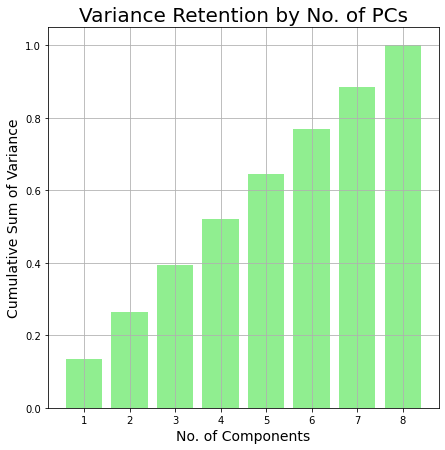

In [41]:
# total number of columns
n = x_trainA.shape[1]

# model definition and fitting
model_pca = KernelPCA(n_components=n, kernel = 'linear', random_state=RANDOM_SEED)
model_pca = model_pca.fit(x_trainA)

# cumulative variance retention
lambdas = model_pca.lambdas_
lambdas = [x/np.sum(lambdas) for x in lambdas]
lambdas_cum = np.array(lambdas).cumsum()

# plot showing variance retention
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.bar(range(1,len(lambdas_cum)+1), lambdas_cum, color = 'lightgreen')
ax.set_xlabel('No. of Components', size = 14)
ax.set_ylabel('Cumulative Sum of Variance', size = 14)
ax.set_title('Variance Retention by No. of PCs', size = 20)
ax.grid()

It's important to note that that cumulative sum of variance, in this case study grows linearly with the number of components. This is very characteristic of full independent datasets. This was expected since we have observed the correlation matrix before, where the input variables are not correlated within themselves

Hence, the application of dimensionality reduction will only serve us for visualization ends. We will reatin 6 components in this study, which will hold almost 80 % of original dataset variance. Let's visualize the scatterplot of the two first components.

#### 4.4.1. Component A Outlet Concentration

In [42]:
# model definition and fitting
model_pca = KernelPCA(n_components=6, kernel = 'rbf', random_state=RANDOM_SEED)
model_pca = model_pca.fit(x_trainA)

cols = []
for i in range(6):
  cols.append('PC' + str(i+1))

# model application
x_trainA_pca = pd.DataFrame(model_pca.transform(x_trainA), columns = cols, index = x_trainA.index)
x_trainA_pca.head(2)

PC1       PC2       PC3       PC4       PC5      PC6
463 -0.131927  0.026836 -0.140077 -0.033339 -0.042882  0.07299
774 -0.220564 -0.048052  0.085544 -0.173434 -0.023154 -0.02271

In [43]:
# joining information of component A outlet concentration and statistical control flag information
x_trainA_pca['target'] = dataA.loc[x_trainA_pca.index, 'componentA_outletConcentration']
x_trainA_pca['flag'] = y_trainA
x_trainA_pca.head(10)

PC1       PC2       PC3       PC4       PC5       PC6    target  \
463  -0.131927  0.026836 -0.140077 -0.033339 -0.042882  0.072990  1.972605   
774  -0.220564 -0.048052  0.085544 -0.173434 -0.023154 -0.022710  1.900333   
3122 -0.198850  0.014135  0.248504  0.248488  0.020561 -0.416068  1.522767   
3117 -0.295631 -0.007988  0.100648 -0.274826  0.177719  0.025737  1.871606   
1177 -0.113532  0.261074  0.177084  0.131194 -0.088075  0.209569  1.710636   
3896  0.136948 -0.105275  0.415086  0.065836  0.036396 -0.297078  1.507519   
1285 -0.039550 -0.287828 -0.449501  0.184692 -0.074846  0.101832  1.658165   
4221  0.054398 -0.226872  0.329040  0.124597  0.421498 -0.100634  1.615328   
953   0.151734  0.038891  0.015110 -0.130474 -0.103443 -0.258551  1.429312   
2743 -0.143120 -0.130282  0.136940  0.070059  0.155543 -0.195411  1.670562   

      flag  
463      1  
774      1  
3122     2  
3117     1  
1177     1  
3896     2  
1285     0  
4221     0  
953      2  
2743     0

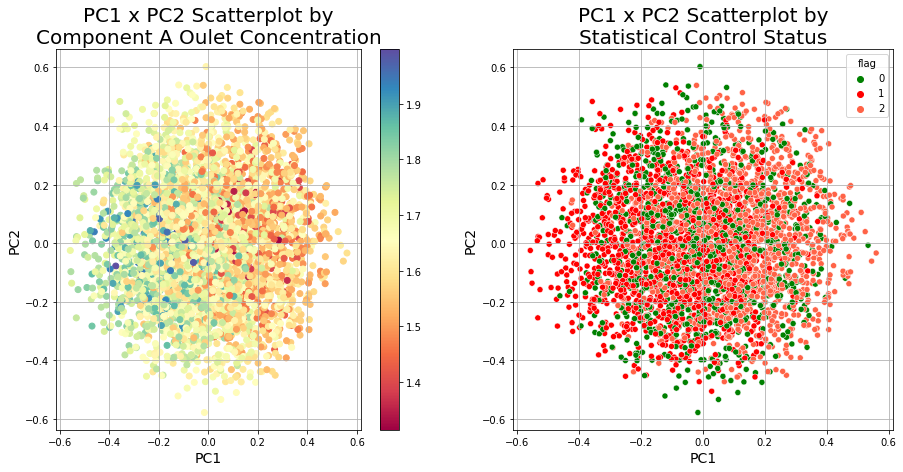

In [44]:
# plotting the scatterplot of the first two components
fig = plt.figure(figsize = (15,7))
cmap = sns.color_palette('Spectral', as_cmap=True)
ax1 = fig.add_subplot(1,2,1)
points = ax1.scatter(x = x_trainA_pca['PC1'], y = x_trainA_pca['PC2'], c = x_trainA_pca['target'], cmap = cmap)
ax1.set_title('PC1 x PC2 Scatterplot by\nComponent A Oulet Concentration', size = 20)
ax1.set_xlabel('PC1', size = 14)
ax1.set_ylabel('PC2', size = 14)
ax1.grid()
plt.colorbar(points)

colors = ['green', 'red', 'tomato']
customPalette = sns.color_palette(colors)

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x = x_trainA_pca['PC1'], y = x_trainA_pca['PC2'], hue = x_trainA_pca['flag'], palette=customPalette)
ax2.set_title('PC1 x PC2 Scatterplot by\nStatistical Control Status', size = 20)
ax2.set_xlabel('PC1', size = 14)
ax2.set_ylabel('PC2', size = 14)
ax2.grid()

As it is possible to check in the first principal components scatterplot, there is no clear division betwwen points inside statistical control and points outside statistical control. Thus, maybe a classification approach will not be efficient in this case.

In addition, the dimensionality reduction technique applied (PCA) did not provide any additional information insight about data distribution and conformity status. According to above scatterplots, there is much overlap between classes of statistical control status.

Hence, the study has changed its approach. Instead of creating a classification model for predicting statistical control status, the study will train a regression modelo, to predict the value of output variable itself, and then determine use the model as reference to ensure statistical control.

An additional step necessary due to this change in modeling strategy, is to change the target variable (y) of train and test sets because we not aiming to predict statistical control category anymore. However, the train-test splitting is maintained because the stratified sampling strategy provided the balance of classes between train and tests sets, which can help the training and generalization of regression model.

Additionaly, it is also necessary to scale the dependent variable, since it is not a category anymore but it is a numerical values. Scaling dependent variable prevents model bias.

In [45]:
# extract the indexes of train and test previous target variables
# component A outlet concentration
idx_trainA = y_trainA.index
idx_testA = y_testA.index

# component B outlet concentration
idx_trainB = y_trainB.index
idx_testB = y_testB.index

# component C outlet concentration
idx_trainC = y_trainC.index
idx_testC = y_testC.index

# extracting the new target values
# component A outlet concentration
y_trainA = dataA.loc[idx_trainA, 'componentA_outletConcentration']
y_testA = dataA.loc[idx_testA, 'componentA_outletConcentration']

# component B outlet concentration
y_trainB = dataB.loc[idx_trainB, 'componentB_outletConcentration']
y_testB = dataB.loc[idx_testB, 'componentB_outletConcentration']

# component C outlet concentration
y_trainC = dataC.loc[idx_trainC, 'componentC_outletConcentration']
y_testC = dataC.loc[idx_testC, 'componentC_outletConcentration']

In [46]:
y_trainA

463     1.972605
774     1.900333
3122    1.522767
3117    1.871606
1177    1.710636
          ...   
2504    1.547717
4766    1.821400
3208    1.634808
1219    1.732083
175     1.665551
Name: componentA_outletConcentration, Length: 3892, dtype: float64

In [47]:
# feature scaling of dependent variable
# component A outlet concentration
scaler_yA = StandardScaler()
scaler_yA = scaler_yA.fit(y_trainA.values.reshape(-1,1))

y_trainA_sc = pd.DataFrame(scaler_yA.transform(y_trainA.values.reshape(-1,1)), 
                           columns = ['componentA_outletConcentration'], index = y_trainA.index)
y_testA_sc = pd.DataFrame(scaler_yA.transform(y_testA.values.reshape(-1,1)), 
                          columns = ['componentA_outletConcentration'], index = y_testA.index)

# component B outlet concentration
scaler_yB = StandardScaler()
scaler_yB = scaler_yB.fit(y_trainB.values.reshape(-1,1))

y_trainB_sc = pd.DataFrame(scaler_yB.transform(y_trainB.values.reshape(-1,1)), 
                           columns = ['componentA_outletConcentration'], index = y_trainB.index)
y_testB_sc = pd.DataFrame(scaler_yB.transform(y_testB.values.reshape(-1,1)), 
                          columns = ['componentA_outletConcentration'], index = y_testB.index)

# component C outlet concentration
scaler_yC = StandardScaler()
scaler_yC = scaler_yC.fit(y_trainC.values.reshape(-1,1))

y_trainC_sc = pd.DataFrame(scaler_yC.transform(y_trainC.values.reshape(-1,1)), 
                           columns = ['componentA_outletConcentration'], index = y_trainC.index)
y_testC_sc = pd.DataFrame(scaler_yC.transform(y_testC.values.reshape(-1,1)), 
                          columns = ['componentA_outletConcentration'], index = y_testC.index)

## 5. Model Building

<br>

For each output variable, except for outlet temperature, a predictive model will be built. This model will act as a "Virtual Online Analyser". This means that for each measure collected by the instruments at plant there will be a prediction of quality related outputs and the reference for correction actions in the process.

Several modeling techniques are tested in this step:

- Multiple Linear Regression
- Kernel SVM Regression
- Decision Tree Regression
- Random Forest

The performance metrics chosen for model evaluation and selection will be the R² metric and the RMSE value. If two models present aproximately the same performance metric, the the simplest model will be selected.


### 5.1. Component A Outlet Concentration

In [48]:
# creating the model dictionary
model_dict = {'Multiple Linear Regression': LinearRegression(),
             'RBF Kernel SVM': SVR(kernel = 'rbf'),
             'Decision Tree': DecisionTreeRegressor(random_state = RANDOM_SEED),
             'Random Forest': RandomForestRegressor(random_state = RANDOM_SEED)}

# function for evaluating models
def model_evaluate(x_train, y_train, x_test, y_test, scaler_y, model, model_name, var_name):
    
    # training selected model in training set
    model = model.fit(x_train, y_train)
    
    # predicting the training set results
    yhat_train_sc = model.predict(x_train)
    
    # predicting test set results
    yhat_sc = model.predict(x_test)
    
    # calculating and showing the performance metrics
    
    # training set
    y_expec_train = scaler_y.inverse_transform(y_train.values)
    yhat_train = scaler_y.inverse_transform(yhat_train_sc)
    
    # test set
    y_expec = scaler_y.inverse_transform(y_test.values)
    yhat = scaler_y.inverse_transform(yhat_sc)
    
    # visualizing the prediction vs expected results and residues analysis
    fig = plt.figure(figsize = (15,15))
    ax1 = fig.add_subplot(2,2,1)
    ax1.plot(y_expec_train, y_expec_train, 'r-', label = 'Expected Value')
    ax1.plot(y_expec_train, yhat_train, 'k.', label = 'Predicted Value')
    ax1.set_xlabel('Expected Value', size = 14)
    ax1.set_ylabel('Predicted Value', size = 14)
    ax1.set_title('Predicted vs Expected - Training Set' + 
                  '\nRMSE: %.4f - R2: %.4f'%(np.sqrt(mean_squared_error(y_expec_train, yhat_train))
                      ,r2_score(y_expec_train, yhat_train)), size = 18)
    ax1.legend()
    ax1.grid()
    
    # training set prediction errors distributions
    ax2 = fig.add_subplot(2,2,2)
    ax2.hist(y_expec_train - yhat_train, color = 'tomato', alpha = .5)
    ax2.set_xlabel('Prediction Error', size = 14)
    ax2.set_ylabel('Frequency', size = 14)
    ax2.set_title('Prediction Error Distribution - Training Set', size = 18)
    ax2.grid()
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.plot(y_expec, y_expec, 'r-', label = 'Expected Value')
    ax3.plot(y_expec, yhat, 'k.', label = 'Predicted Value')
    ax3.set_xlabel('Expected Value', size = 14)
    ax3.set_ylabel('Predicted Value', size = 14)
    ax3.set_title('Predicted vs Expected - Test Set' + 
                  '\nRMSE: %.4f - R2: %.4f'%(np.sqrt(mean_squared_error(y_expec, yhat))
                      ,r2_score(y_expec, yhat)), size = 18)
    ax3.legend()
    ax3.grid()
    
    # training set prediction errors distributions
    ax4 = fig.add_subplot(2,2,4)
    ax4.hist(y_expec - yhat, color = 'blue', alpha = .5)
    ax4.set_xlabel('Prediction Error', size = 14)
    ax4.set_ylabel('Frequency', size = 14)
    ax4.set_title('Prediction Error Distribution - Test Set', size = 18)
    ax4.grid()
    
    # final configurations
    plt.suptitle('Model Prediction Evaluation - ' + model_name + ' - ' + var_name, size = 22)
    plt.subplots_adjust(top = 0.90)

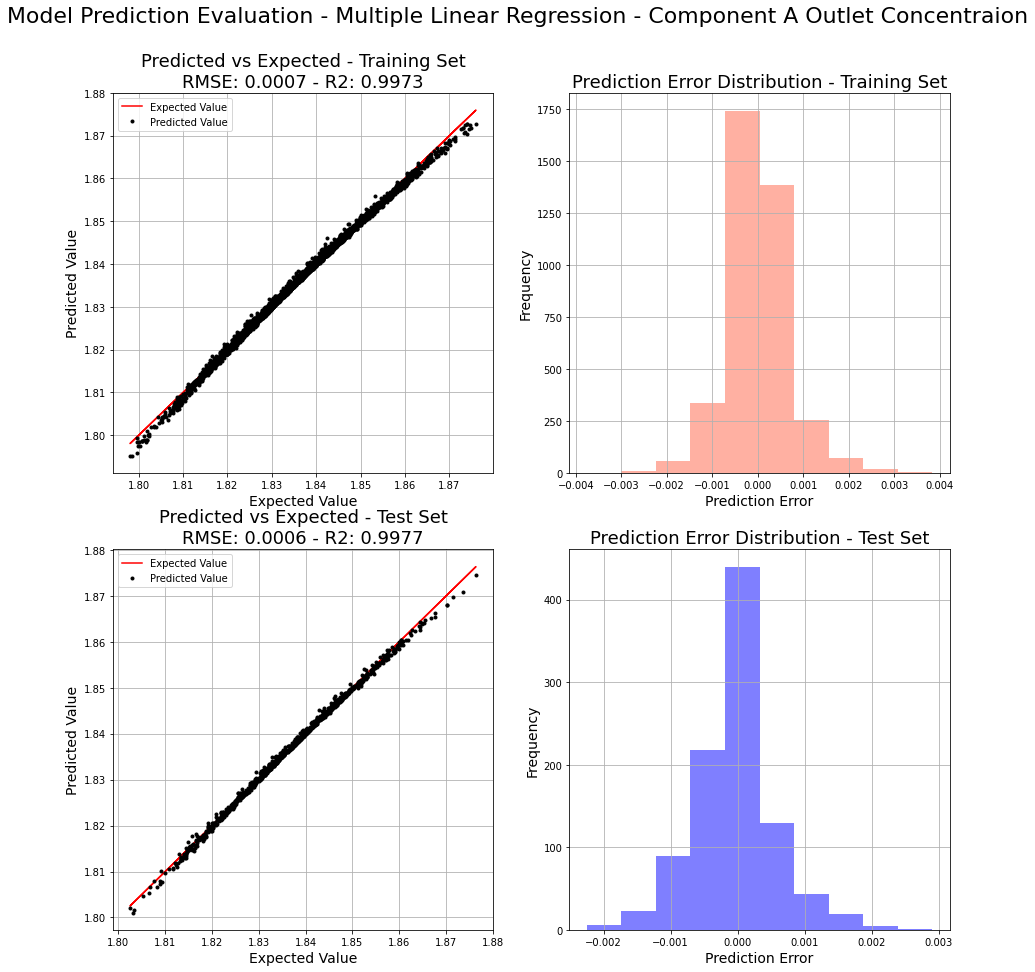

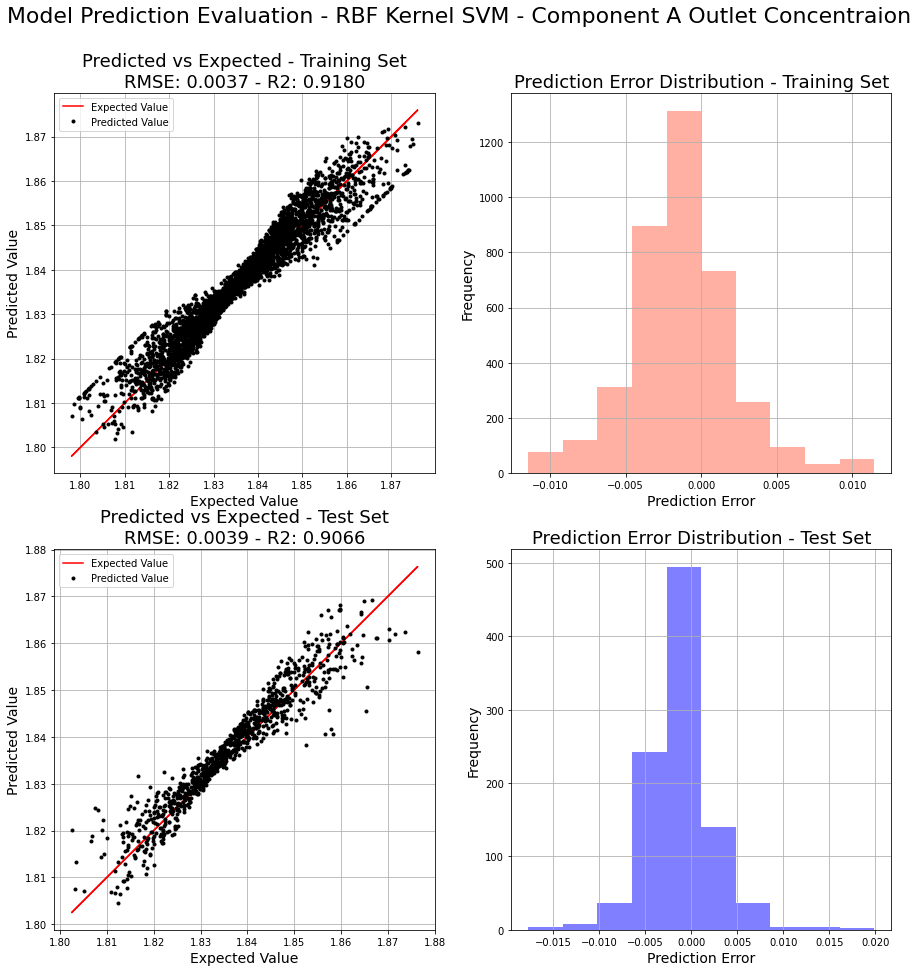

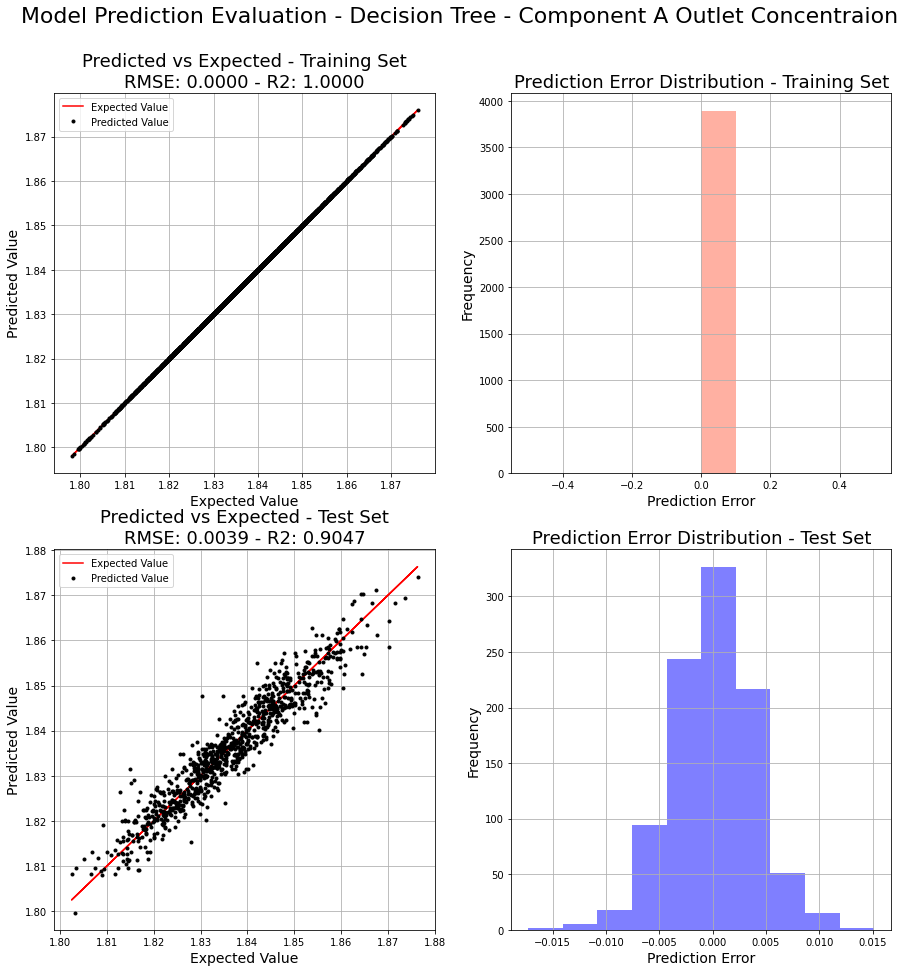

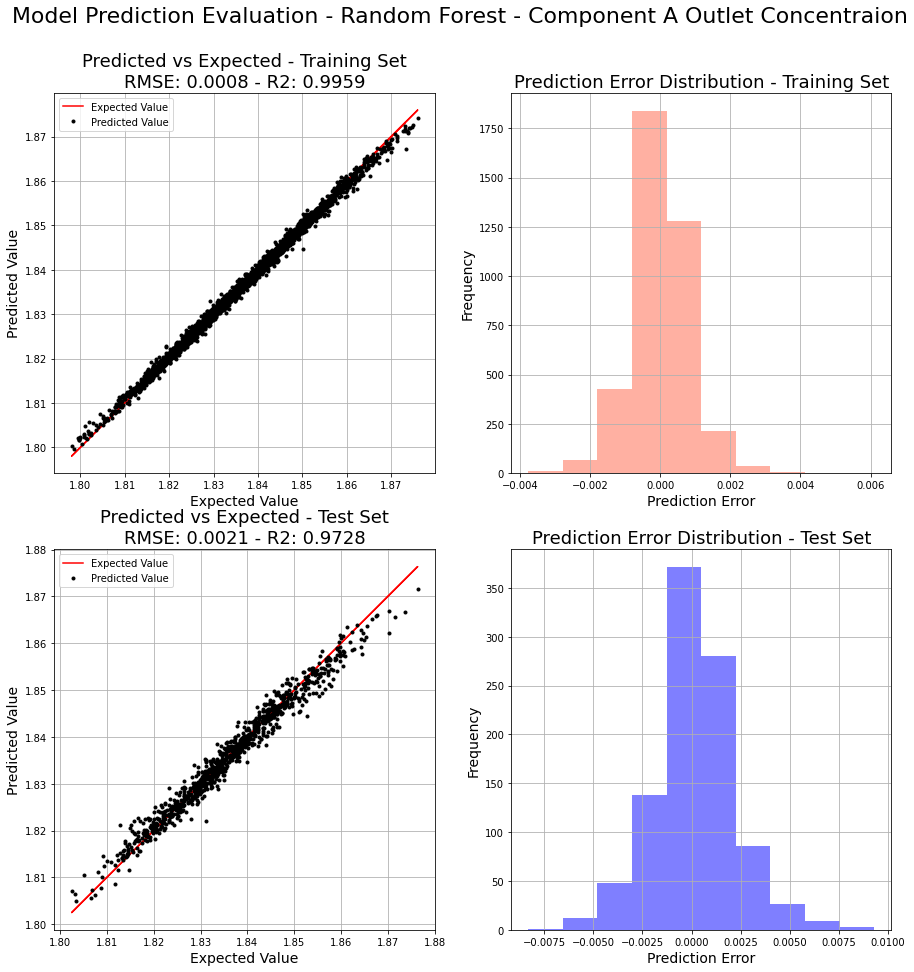

In [49]:
# several regression models evaluated
for name in model_dict:
    model_evaluate(x_trainA, y_trainA, x_testA, y_testA, scaler_yA, model_dict[name], name, 
                       'Component A Outlet Concentraion')

The Multiple Linear Regression model is the most appropriate for the prediction of component A outlet concentration, because it presented both good capacity of prediction and not overfitted the data.

In addition, the histograms showed that the prediction errors are symmetrical with mean 0, having a normal behavior. Also, it is important to notice that the linear model had the capacity to produce very low prediction errors.

<br>

### Component B Outlet Concentration

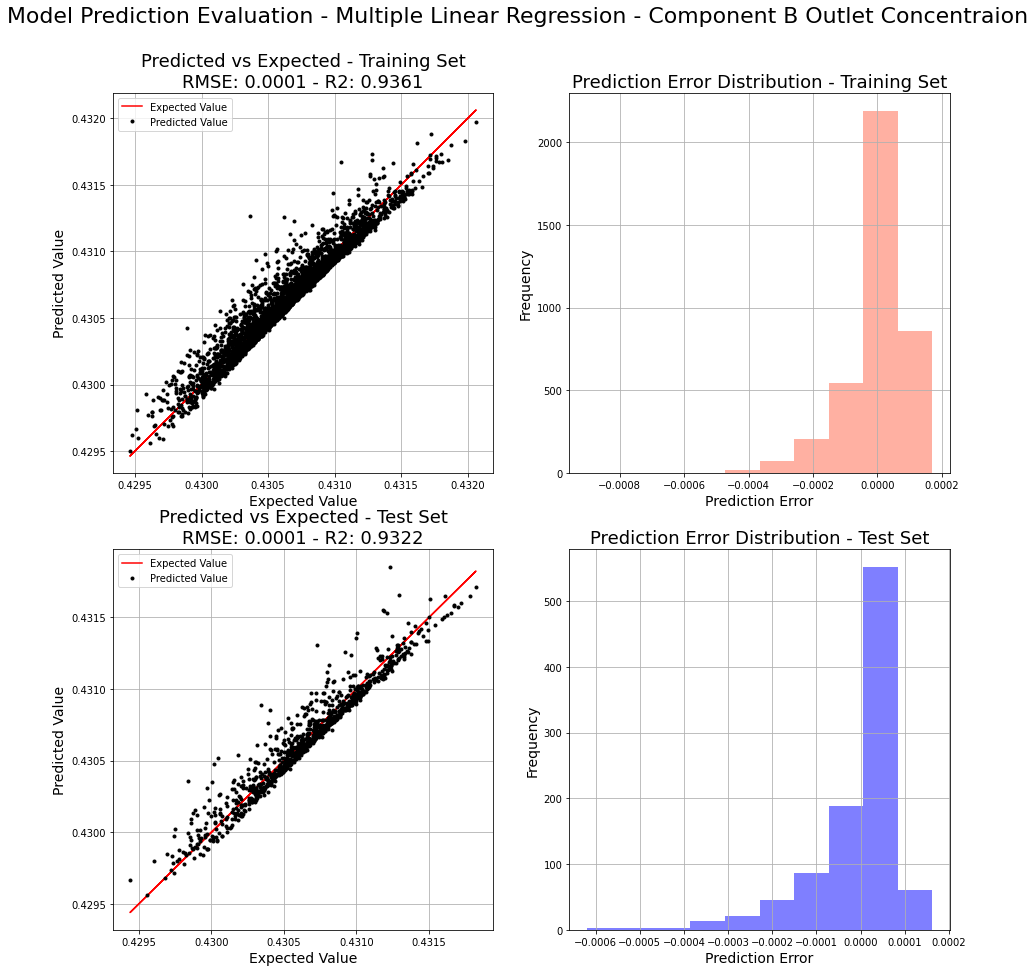

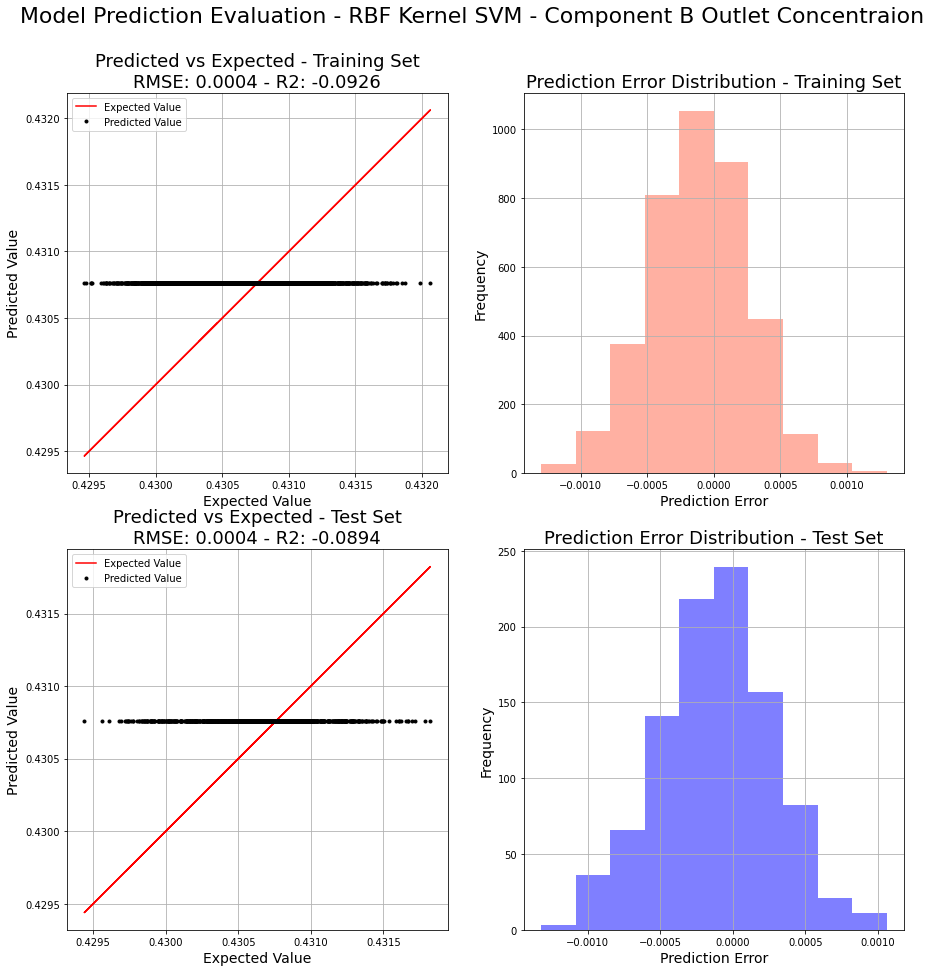

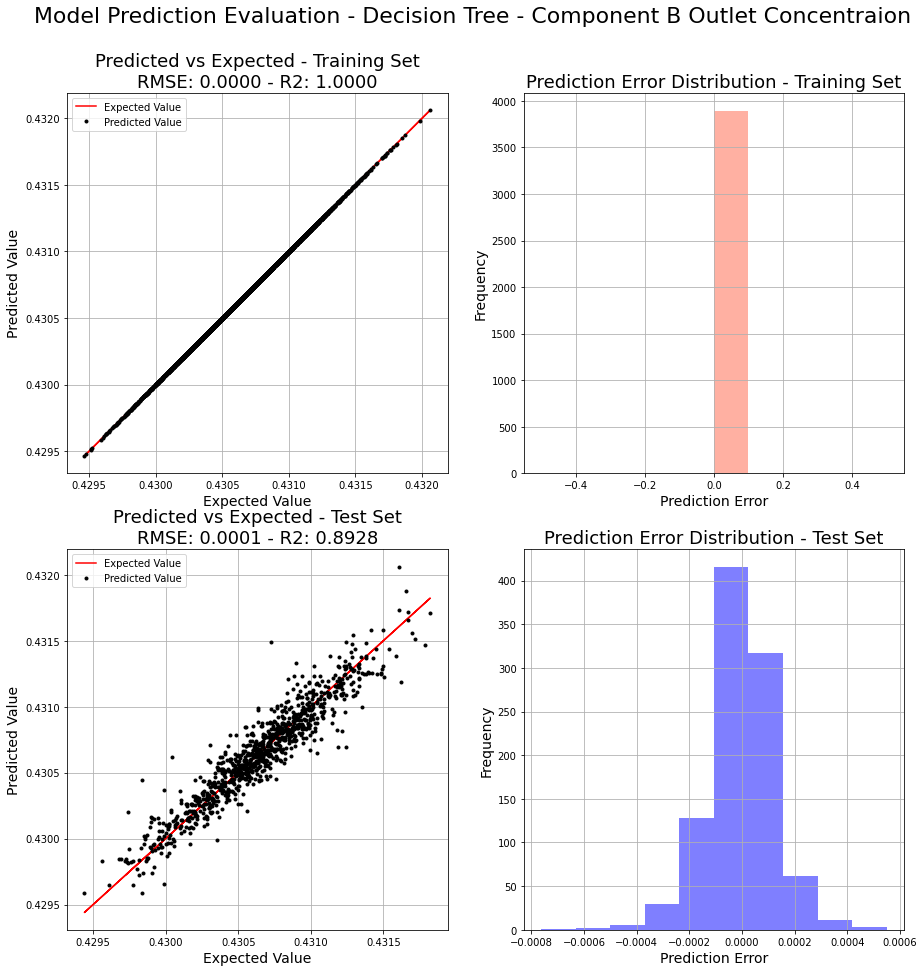

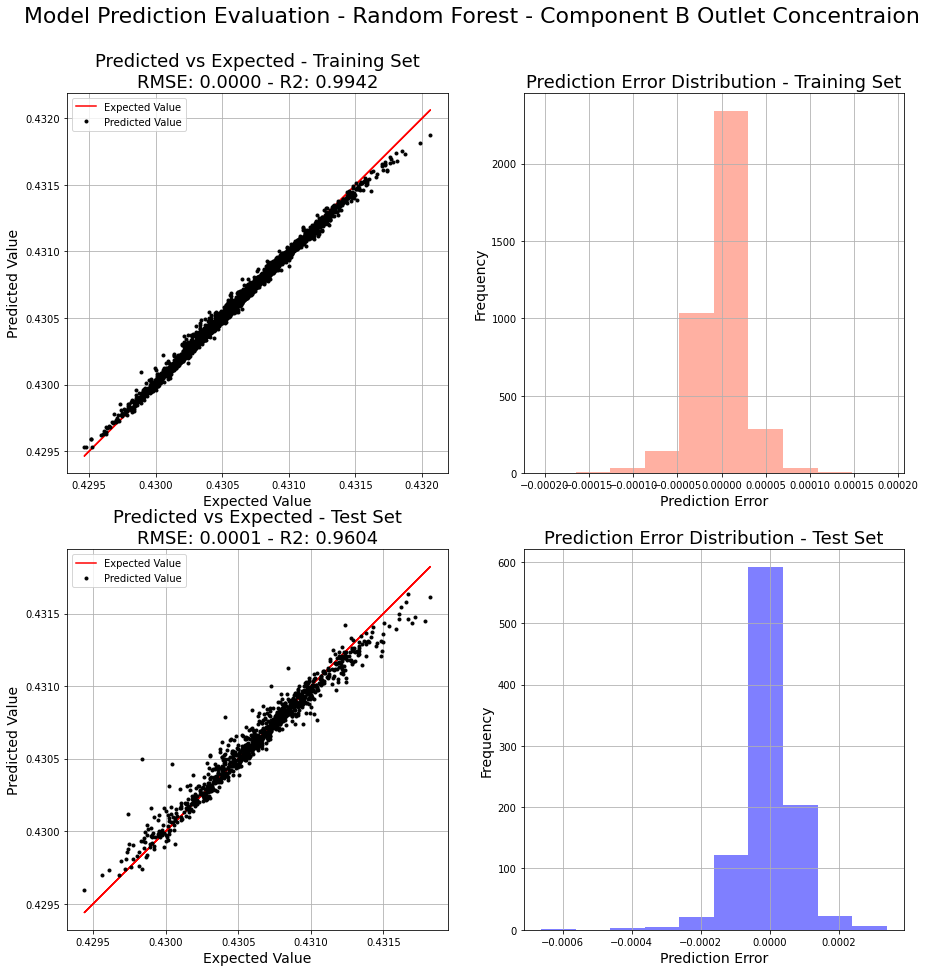

In [50]:
# several regression models evaluated
for name in model_dict:
    model_evaluate(x_trainB, y_trainB, x_testB, y_testB, scaler_yB, model_dict[name], name, 
                       'Component B Outlet Concentraion')

The component B outlet concentration presented a different behavior when compared to the component A outlet concentration. Best model for this quality related output happened to be Random Forest model.

<br>

A possible explanation for this observation is that the component A output concentration is most affected by the linear terms of mass balance, which correspond to the inlet concentration of A, the flow rate of water and the flow rate of solution A. On the other hand, the component B is also affected by the non linear term, which is the reaction term, because it is the limitant reactant.

Although the Random Forest showed the best performance, it can also be seen a little bit of overfitting, because the performance metrics of test set are lower than the observed for the training set. Nevertheless, the Random Forest was capable of predicting the outlet concentration of component B with a very good exactness.

### 5.3. Component C Outlet Concentration

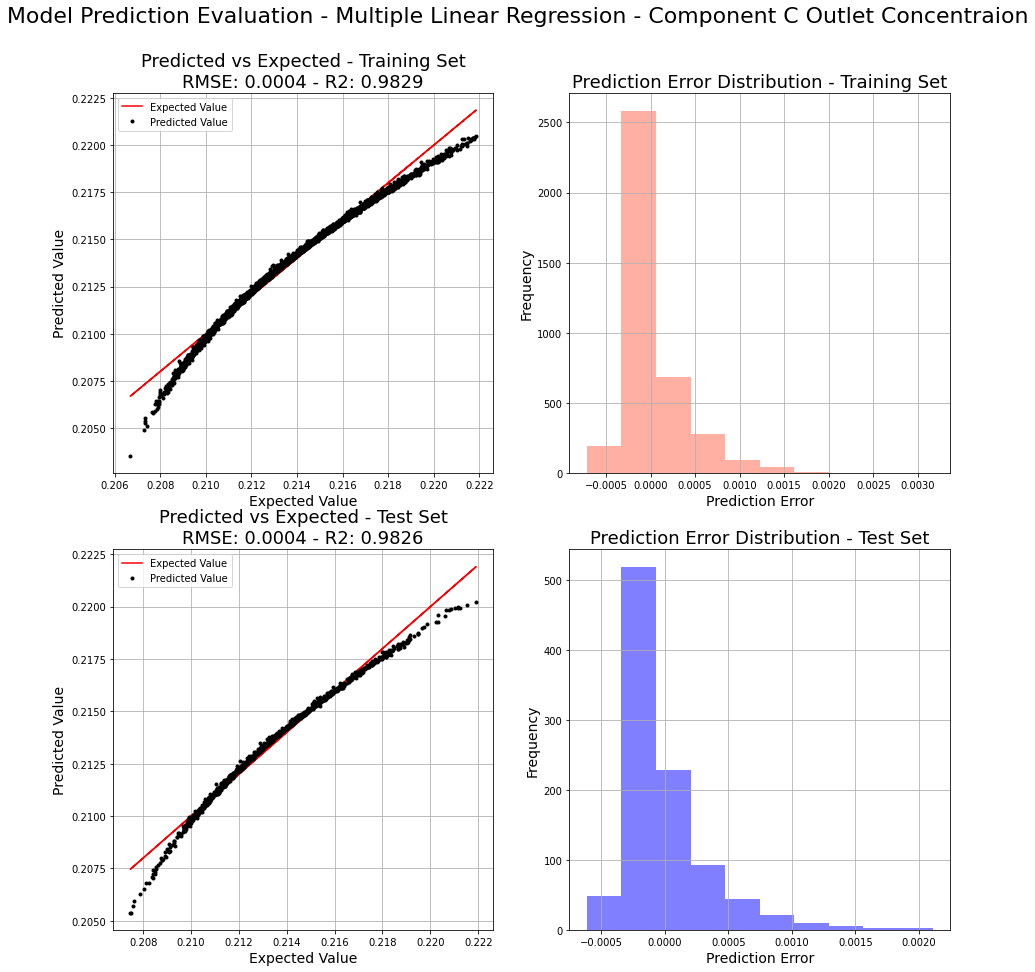

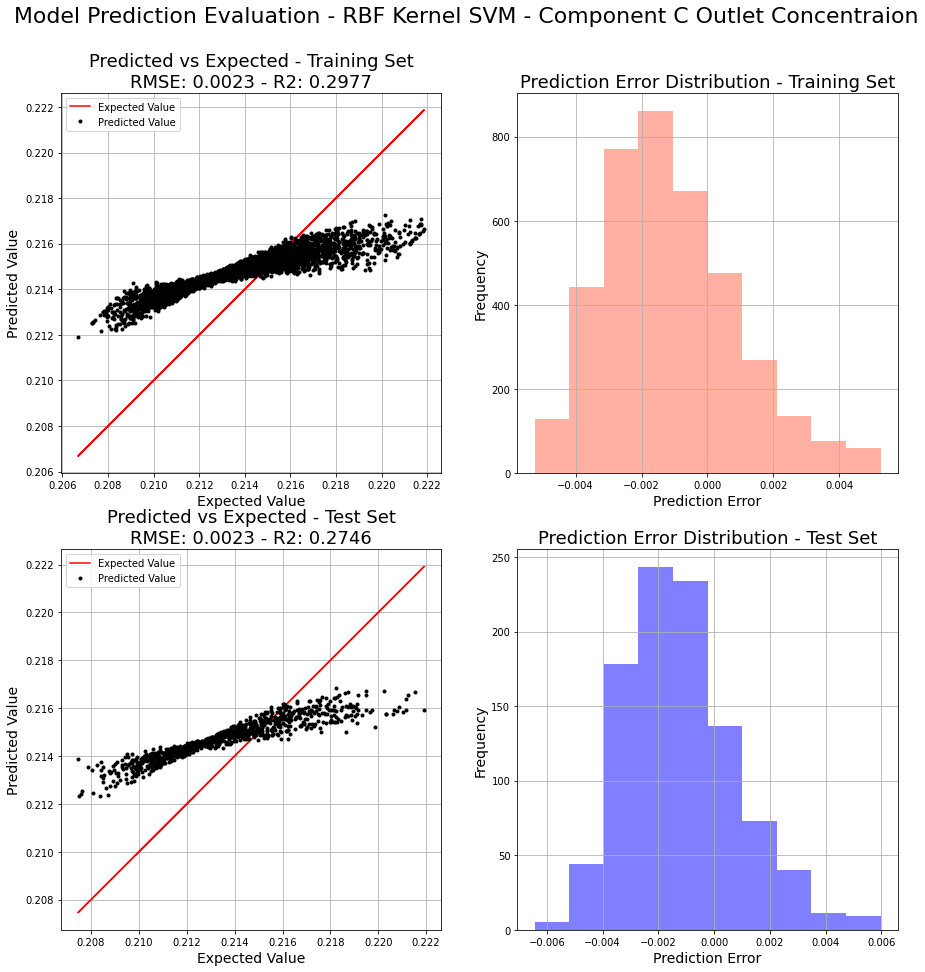

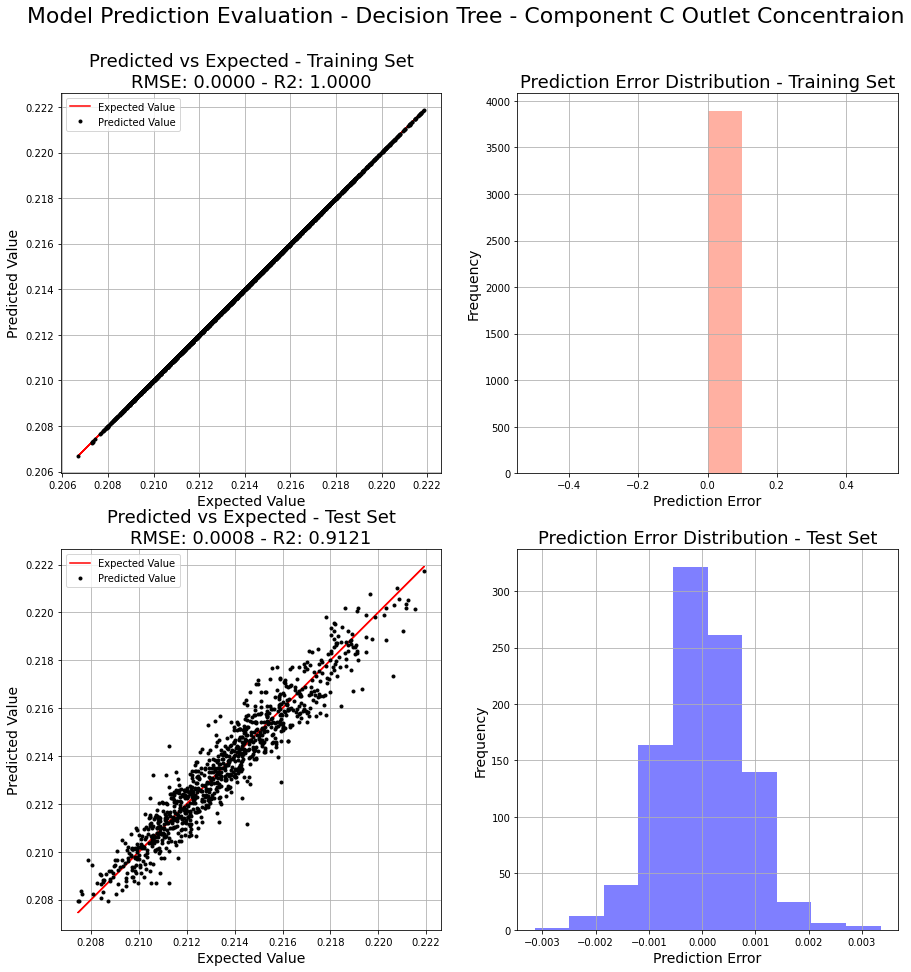

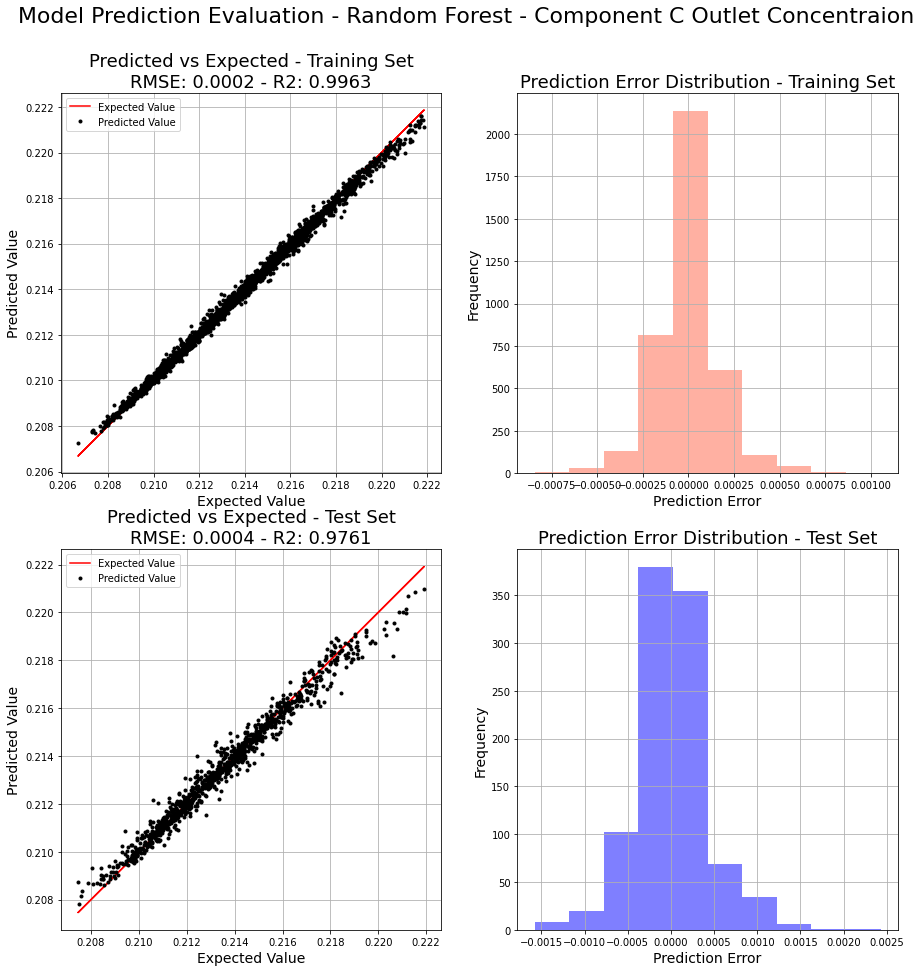

In [51]:
# several regression models evaluated
for name in model_dict:
    model_evaluate(x_trainC, y_trainC, x_testC, y_testC, scaler_yC, model_dict[name], name, 
                       'Component C Outlet Concentraion')

The outlet concentration of component C follows, aproximately, the same idea drawn from the observations of component B's behavior. Since the only term affecting the concentration of C at outlet stream is the reaction term, then it is expected to have some non-linear effects in this data.

Hence, the Random Forest model fitted such values very nicely, although it presented a little degree of overfitting. Moreover, it was capable of predicting outlet concentration of C very precisely, as it is shown in prediction errors histograms.

However, for this application, all models are considered satisfactory and thus no hyperarmeters tuning will be performed.

<br>

## 6. Virtual Online Analyser

<br>

Now that predictive models are trained and validated, the focus is to use them. The first application developed is the VOA (Virtual Online Analyser) which is a tool to monitor the quality using only the input variables.

The VOA application is very useful for monitoring variables that are difficult and/or expensive to anaylise frequently. The main idea behind VOA is to estimate the value of such variables using a predictive model, using the input process variables as input.

Our application of VOA will be tested against variations of the input process variables.

### 6.1. Changes in Inlet Flow Rates

<br>

#### 6.1.1. Component A Outlet Concentration

In [55]:
def simulate_flow_step(STREAM, END_TIME, STEP_START, STEP_STOP, STEP_SLOPE, data, model, scaler, y_name):
    
    # setting the simulation parameters up
    END_TIME*=60 # converting simulation time from minutes to seconds
    START_TIMESTMP = datetime.datetime.now()
    STEP_START = [x*60 for x in STEP_START]
    STEP_STOP = [x*60 for x in STEP_STOP]
    
    STREAM_DICT = {'water': 'water_inletFlowRate',
                  'A': 'solutionA_inletFlowRate',
                  'B': 'solutionB_inletFlowRate'}
    
    STREAM_STEP = []
    for name in STREAM:
        STREAM_STEP.append(STREAM_DICT[name])
        
    # checking process variables when quality variable is inside statistical control
    data_control = data.loc[data['CONTROL'] == 0]
    stats = data_control.describe()

    # column definitions for simulation dataframe
    cols = list(data_control.columns)
    cols.remove('CONTROL')
    cols[0] = 'Timestamp'
    
    # extracting predictors columns
    x_cols = list(data_control.columns)
    to_drop = [y_name, 'CONTROL']
    x_cols = [x for x in x_cols if x not in to_drop]

    # definition of simulation dataframe
    sim_data = pd.DataFrame(columns = cols)

    # extracting the mean values of process variables
    data_cols = list(data_control.columns)
    data_cols.remove('CONTROL')
    avg = stats.loc['mean', data_cols]
    
    # filling the first row
    sim_data.loc[0, 'Timestamp'] = START_TIMESTMP
    sim_data.loc[0, avg.index] = avg

    # filling the remaining rows
    for i in range(1,END_TIME+1):
        sim_data.loc[i, 'Timestamp'] = START_TIMESTMP + datetime.timedelta(seconds = i)
        sim_data.loc[i, avg.index] = np.random.normal(loc = avg, scale = avg*0.00005)
        
        for j in range(len(STEP_START)):
            if (i >= STEP_START[j]) & (i <= STEP_STOP[j]):
                sim_data.loc[i, STREAM_STEP[j]] = avg.loc[avg.index == STREAM_STEP[j]].values + \
                (STEP_SLOPE[j]*(i-STEP_START[j]))
            elif (i > STEP_STOP[j]):
                sim_data.loc[i, STREAM_STEP[j]] = avg.loc[avg.index == STREAM_STEP[j]].values + \
                (STEP_SLOPE[j]*(STEP_STOP[j]-STEP_START[j]))

    # transforming index
    sim_data.set_index(pd.DatetimeIndex(sim_data['Timestamp']), inplace = True)
    sim_data.drop(['Timestamp'], axis = 1, inplace = True)
    
    # after simulating points,extract predictors, preprocess them and make prediction with VOA model
    data_pipeline = Pipeline([('scaler', scaler)])
    x_predictors = sim_data.loc[sim_data.index, x_cols]
    x_predictors = data_pipeline.transform(x_predictors)
    
    sim_data.loc[sim_data.index, y_name] = model.predict(x_predictors)
    
    return sim_data

In [60]:
# simulation parameters
STREAM = ['water', 'A', 'B']
END_TIME = 120
STEP_START = [30, 75, 10]
STEP_STOP = [45, 90, 15]
STEP_SLOPE = [0.1/60, -0.05/60, 0.2/60]

# training final model
model_cA = LinearRegression()
model_cA = model_cA.fit(x_trainA, y_trainA)

# making simulation
sim_dataA = simulate_flow_step(STREAM, END_TIME, STEP_START, STEP_STOP, STEP_SLOPE, dataA, 
                               model = model_cA, scaler = scalerA,
                              y_name = 'componentA_outletConcentration')

Text(0, 0.5, 'ComponentA Outlet\nConcentration')

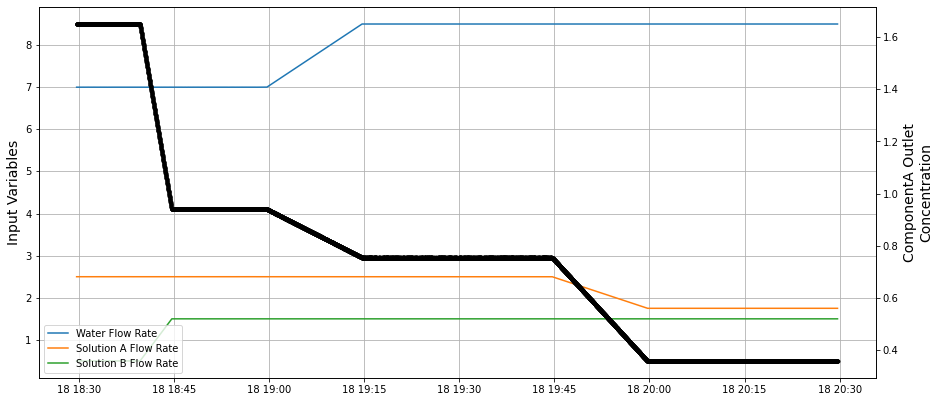

In [61]:
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(sim_dataA['water_inletFlowRate'], label = 'Water Flow Rate')
ax1.plot(sim_dataA['solutionA_inletFlowRate'], label = 'Solution A Flow Rate')
ax1.plot(sim_dataA['solutionB_inletFlowRate'], label = 'Solution B Flow Rate')
ax1.set_ylabel('Input Variables', size = 14)
ax1.grid()
ax1.legend(loc = 'lower left')

ax2 = ax1.twinx()
ax2.plot(sim_dataA['componentA_outletConcentration'], 'k.')
ax2.set_ylabel('ComponentA Outlet\nConcentration', size= 14)

In [ ]:
sim_dataA